# 价格优化策略 A/B 测试

> 作者：黄桥 (Qiao Huang) <www.uniqiao.com> (c) All rights reserved.
>
> > 求职中，欢迎联系 <qiao@uniqiao.com> Job hunting, welcome to reach me!

_**Changelog:**_


| Date (YYYY-MM-DD) | Version | Change Description                             |
| ----------------- | ------- | ---------------------------------------------- |
| 2022-01-30        | 1.0     | Finish initial version of the Jupyter Notebook |
| 2022-02-17        | 1.1     | Fix Jupyter nbviewer rendering issues          |

![A/B Testing](images/AB-Testing.jpg)

<cite>Image Source: <a href="https://www.google.com/imghp">Google Images</a></cite>

<a name=toc></a> **目录：**

- 0. [背景与目标](#0)
- 1. [数据预热](#1)
  - 1.1 [数据说明](#1.1)
  - 1.2 [`user` 数据处理](#1.2)
  - 1.3 [`test` 数据处理](#1.3)
  - 1.4 [数据融合](#1.4)
  - 1.5 [数据准备](#1.5)
- 2. [随机分配检验](#2)
  - 2.1 [数值数据 t-test 检验](#2.1)
  - 2.2 [时间序列随机检验](#2.2)
  - 2.3 [类别数据 chi2-test 检验](#2.3)
  - 2.4 [利用树模型检验](#2.4)
- 3. [怎么定价](#3)
  - 3.1 [整体分析](#3.1)
  - 3.2 [细分群体](#3.2)
  - 3.3 [最终结论](#3.3)
- 4. [何时结束](#4)
  - 4.1 [计算样本量](#4.1)
  - 4.2 [计算终止时期](#4.2)
- 5. [数据总览](#5)
  - 5.1 [转化率考察](#5.1)
  - 5.2 [指标体系搭建](#5.2)
  - 5.3 [行动方案](#5.3)
- 6. [结语](#6)
- 7. [参考资料](#7)

## <a name="0"></a> 0. 背景与目标

[回到目录](#toc)

**价格优化**能为公司提供巨大的价值，一个好的定价策略不仅能增加营收，还可以筛选出目标客户，减少运营成本。

**背景：**

一家 SaaS 公司主要业务的服务定价为 \$39。因为营收长时间都没有增长，产品团队决定运行一个线上对照实验，验证增加产品的价格是否能增加营收。实验数据分为两组，约 66% 的用户分配到对照组，即原来的价格 \$39，约 33% 的用户分配到实验组，一个更高的价格 \$59。

<!-- (www.uniQiao.com | Qiao Huang) just a mark, please ignore it. -->

实验已经进行了一段时间，并产生了大量的用户数据，产品团队决定对现有实验数据进行分析，来决定如何定价，以及得到一些重要洞见。

**目标：**

1. 为了做出有利决策，实验是否成功，**怎么定价**，\$39 or \$59？
2. 为了减少**时间成本**，实验该在什么时候结束？
3. 为了进一步增加营收，特别观察**转化率**，从数据中还有什么发现和建议？

## <a name="1"></a> 1. 数据预热

[回到目录](#toc)

**环境搭建：**

首先加载我们所需的包。其中 `geopandas` 包依赖复杂，最好创建一个新的虚拟环境，这里采用 `Conda` 包管理工具：

```shell
conda create —-name geo-env
conda activate geo-env
conda install -c conda-forge geopandas
```

In [1]:
# Import libraries

import numpy as np
import pandas as pd

import math
from scipy import stats

from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

from matplotlib import pyplot as plt
from matplotlib_venn import venn2, venn2_circles
import seaborn as sns

import pydotplus
from IPython.display import Image

import geopandas as gpd
import mplleaflet as mpll

import time
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


%matplotlib inline
plt.style.use('fivethirtyeight') # the best style ever

seed = 2022 # for reproduce

### <a name="1.1"></a> 1.1 数据说明

[回到目录](#toc)

我们有两个两份表格数据：

**`user` table**：包含用户数据，主要是地理信息

  - `user_id`: 用户 ID，可用于连接另一个表
  - `city`: 用户所在城市，来自于 IP 地址
  - `country`: 用户所在国家
  - `lat`: 城市纬度
  - `long`: 城市经度


**`test` table**: 包含测试数据，收集于线上对照实验

  - `user_id`: 用户 ID，可用于连接另一个表
  - `timestamp`: 用户首次点击页面日期时间
  - `source`: 营销渠道
    - `ads`: 包含 `google`, `facebook`, `bing`, `yahoo`, `other`
    - `seo`: 包含 `google`, `facebook`, `bing`, `yahoo`, `other`
    - `friend_referral`: 来自于其他用户的分享链接
    - `direct_traffic`: 用户直接输入网站地址而来
  - `device`: 用户设备，分为 `mobile` 和 `web`
  - `operative_system`: 用户操作系统
    - `windows, linux, mac`: web 端
    - `android, iOS`: mobile 端
    - `Other`: 其它操作系统
  - `test`: 用户是否在实验组
    - `0`: 对照组，价格为 \$39
    - `1`: 实验组，价格为 \$59
  - `price`: 用户看到的价格，应与 `test` 匹配
  - `converted`: 用户是否转化
    - `0`: 没有购买
    - `1`: 购买服务

<cite>Data Source: <a href="https://www.linkedin.com/in/giuliopalombo/">Giulio Palombo</a></cite>

### <a name="1.2"></a> 1.2 `user` 数据处理

[回到目录](#toc)

**加载数据：**

In [2]:
df_user = pd.read_csv('datasets/user.csv', dtype={'user_id': str})
df_user.head()

,user_id,city,country,lat,long
0,510335,Peabody,USA,42.53,-70.97
1,89568,Reno,USA,39.54,-119.82
2,434134,Rialto,USA,34.11,-117.39
3,289769,Carson City,USA,39.15,-119.74
4,939586,Chicago,USA,41.84,-87.68


**预览数据：**

In [3]:
print("Data shape:", df_user.shape, "\n")

print("Data 10 samples:")
df_user.sample(10, random_state=seed)

Data shape: (275616, 5) 

Data 10 samples:


,user_id,city,country,lat,long
268137,993114,Centennial,USA,39.60,-104.85
242536,543411,Indianapolis,USA,39.78,-86.15
50310,184079,Billerica,USA,42.56,-71.26
203988,524077,Tucson,USA,32.20,-110.89
260445,552254,Beverly,USA,42.56,-70.84
46157,171389,Philadelphia,USA,40.01,-75.13
31259,591189,Hoffman Estates,USA,42.06,-88.14
28261,144104,Cape Coral,USA,26.64,-82.00
63660,392927,Dayton,USA,39.78,-84.20
12225,435208,Aurora,USA,39.71,-104.73


**描述性统计信息：**

In [4]:
df_user.describe(include='all')

,user_id,city,country,lat,long
count,275616,275616,275616,275616.000000,275616.000000
unique,275616,923,1,NaN,NaN
top,510335,New York,USA,NaN,NaN
freq,1,25748,275616,NaN,NaN
mean,NaN,NaN,NaN,37.111680,-93.981772
std,NaN,NaN,NaN,5.209627,18.086486
min,NaN,NaN,NaN,19.700000,-157.800000
25%,NaN,NaN,NaN,33.660000,-112.200000
50%,NaN,NaN,NaN,37.740000,-88.930000
75%,NaN,NaN,NaN,40.700000,-78.910000


我们看到 `country`一栏只出现 `USA` 一个国家。

**检查空值和字段属性：**

In [5]:
df_user.info()

df_user.applymap(type).apply(pd.value_counts).fillna(0)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275616 entries, 0 to 275615
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   user_id  275616 non-null  object 
 1   city     275616 non-null  object 
 2   country  275616 non-null  object 
 3   lat      275616 non-null  float64
 4   long     275616 non-null  float64
dtypes: float64(2), object(3)
memory usage: 10.5+ MB


,user_id,city,country,lat,long
<class 'str'>,275616.0,275616.0,275616.0,0.0,0.0
<class 'float'>,0.0,0.0,0.0,275616.0,275616.0


**检查重复值：**

- 主要看 `user_id`

In [6]:
df_user[df_user.duplicated(subset=['user_id'], keep=False)]

,user_id,city,country,lat,long


**检查异常值：**

- 主要看数值类信息，即经纬度 `lat` and `long`

In [7]:
df_lat_long_extreme = df_user.describe().loc[['min', 'max'], ['lat', 'long']]
df_lat_long_extreme

,lat,long
min,19.70,-157.80
max,61.18,30.31


- 转化成对应的城市 `city`

In [8]:
df_city_extreme = df_lat_long_extreme.apply(
    {'lat': lambda x: df_user.city[df_user['lat']==x].unique()[0],
    'long': lambda x: df_user.city[df_user['long']==x].unique()[0]})
df_city_extreme

,lat,long
min,Hilo,Honolulu
max,Anchorage,Saint Petersburg


上表中圣彼得堡 (Saint Petersburg) 属于俄罗斯，初步判定数据有异常，我们进行可视化分析。

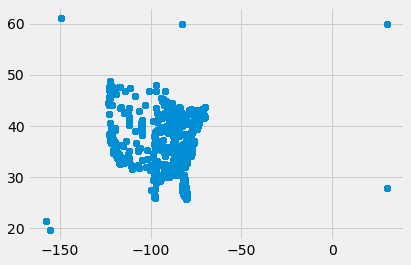

In [9]:
plt.scatter(df_user['long'], df_user['lat'])
plt.show()

通过绘制散点图，发现了几个离群点。

查看维基百科：[List of extreme points of the United States](https://en.wikipedia.org/wiki/List_of_extreme_points_of_the_United_States)

![Extreme USA](images/ExtremeUS1.jpg)

Extreme points in the 50 states: 
  
- "Latitude":
    - (⬆ `71.39`) Point Barrow
    - (⬇ `18.99`) Ka Lae
- "Longitude":
    - (⬅ `-172.44`) Peaked Island
    - (➡ `-66.95`) Sail Rock

对比发现，在散点图上方和右方均出现了异常值，我们对 `lat > 50` 及 `long > -50` 的数据坐标进行重点检测。

In [10]:
df_extremes = df_user[(df_user['lat'] > 50) | (df_user['long'] > -50)]
df_extremes.describe(include='all')

,user_id,city,country,lat,long
count,1051,1051,1051,1051.000000,1051.000000
unique,1051,2,1,NaN,NaN
top,209434,Saint Petersburg,USA,NaN,NaN
freq,1,529,1051,NaN,NaN
mean,NaN,NaN,NaN,56.112540,-79.476299
std,NaN,NaN,NaN,11.362478,79.286781
min,NaN,NaN,NaN,27.760000,-149.190000
25%,NaN,NaN,NaN,59.930000,-149.190000
50%,NaN,NaN,NaN,59.930000,-82.640000
75%,NaN,NaN,NaN,61.180000,30.310000


发现有两个城市，为方便查看，进行数据透视。

In [11]:
table_user_extremes = pd.pivot_table(df_extremes, 
                                     values='user_id',
                                     index=['lat', 'long'], 
                                     columns=['city', 'country'], 
                                     aggfunc='count', 
                                     fill_value=0)
table_user_extremes

city          Anchorage Saint Petersburg
country             USA              USA
lat   long                              
27.76  30.31          0              145
59.93 -82.64          0              192
       30.31          0              192
61.18 -149.19       522                0

**清理数据：**

- 由上面数据透视表，发现只有 `Saint Petersburg` 一个城市异常，并且出现了三个不同的地理位置。由于数据量较少，我们可直接剔除。

- 因为 `country` 字段无有用信息，我们进行 `drop` 处理。

In [12]:
df_user_cleaned = df_user[df_user['city'] != 'Saint Petersburg']\
                  .drop(columns='country')
df_user_cleaned.describe(include='all')

,user_id,city,lat,long
count,274911,274911,274911.000000,274911.000000
unique,274911,922,NaN,NaN
top,510335,New York,NaN,NaN
freq,1,25748,NaN,NaN
mean,NaN,NaN,37.090727,-94.149317
std,NaN,NaN,5.136144,17.573333
min,NaN,NaN,19.700000,-157.800000
25%,NaN,NaN,33.660000,-112.240000
50%,NaN,NaN,37.740000,-89.020000
75%,NaN,NaN,40.700000,-79.040000


如上表，经清理后，`city` 去除了一个异常类别，剩余 922 个，Column `drop` 掉了 `country` 一栏，还剩四个。

**数据可视化：**

至此，`user` 数据清理完毕，最后不妨再绘制城市散点图。

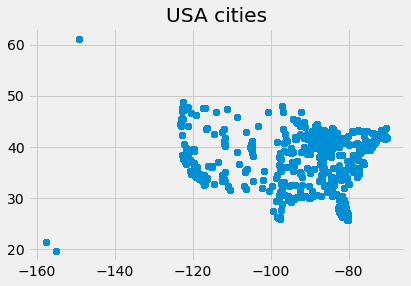

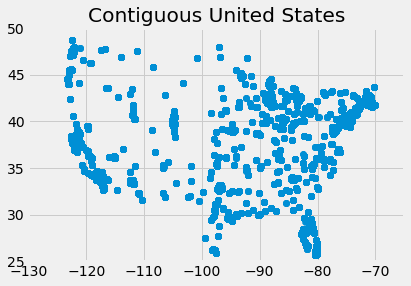

In [13]:
plt.title('USA cities')
plt.scatter(df_user_cleaned['long'], df_user_cleaned['lat'])
plt.show()

plt.title('Contiguous United States')
plt.scatter(df_user_cleaned['long'], df_user_cleaned['lat'])
plt.xlim([-130, -65])
plt.ylim([25, 50])
plt.show()

绘制 `JointGrid`，查看联合分布。

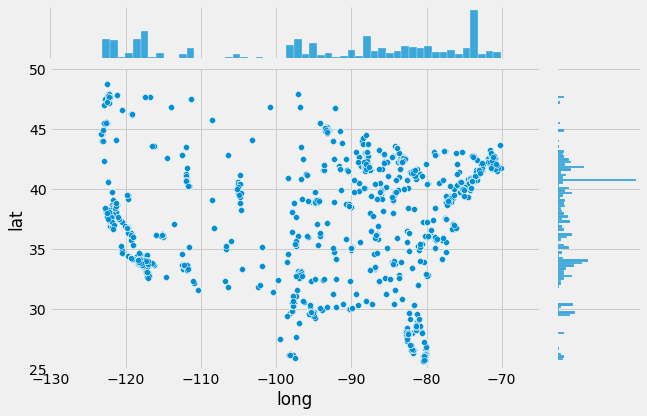

In [14]:
# sns.set_style('darkgrid')

jplot = sns.jointplot(data=df_user_cleaned, x='long', y='lat')
jplot.ax_marg_x.set_xlim(-130, -65)
jplot.ax_marg_y.set_ylim(25, 50)
jplot.fig.set_figwidth(10)
jplot.fig.set_figheight(6)

plt.show()

由数据点分布发现，用户主要分布在东西海岸和黄金北纬上，这也是大城市主要集中地。

### <a name="1.3"></a> 1.3 `test` 数据处理

[回到目录](#toc)

**加载数据：**

In [15]:
df_test = pd.read_csv('datasets/test.csv', dtype={'user_id': str},
                      parse_dates=['timestamp']) # read to datetime type
df_test.head()

,user_id,timestamp,source,device,operative_system,test,price,converted
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0


**预览数据：**

In [16]:
print("Data shape:", df_test.shape, "\n")

print("Data 10 sample:")
df_test.sample(10, random_state=seed)

Data shape: (316800, 8) 

Data 10 sample:


,user_id,timestamp,source,device,operative_system,test,price,converted
99874,315465,2015-03-14 10:43:49,friend_referral,web,mac,1,59,0
220661,463206,2015-03-27 10:35:04,ads-bing,mobile,android,0,39,0
285216,175817,2015-04-11 10:46:53,friend_referral,web,windows,0,39,0
48540,409365,2015-05-01 08:37:08,ads_facebook,mobile,iOS,0,39,0
220525,548355,2015-03-16 06:57:34,ads_facebook,mobile,iOS,1,59,0
81961,228343,2015-05-20 16:50:57,ads_facebook,web,mac,1,59,0
1074,246965,2015-05-02 07:19:22,ads_other,mobile,iOS,0,39,0
206683,606659,2015-05-03 08:52:08,ads-bing,web,windows,1,39,0
279246,73658,2015-05-15 12:19:48,seo_facebook,mobile,other,0,39,0
20274,358500,2015-04-10 16:59:44,friend_referral,web,windows,1,59,0


**描述性统计信息：**

In [17]:
df_test.describe(include='all')

,user_id,timestamp,source,device,operative_system,test,price,converted
count,316800,316800,316800,316800,316800,316800.000000,316800.000000,316800.000000
unique,316800,140931,12,2,6,NaN,NaN,NaN
top,604839,2015-04-12 11:51:16,direct_traffic,mobile,windows,NaN,NaN,NaN
freq,1,12,60357,186471,100976,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,0.360079,46.205051,0.018333
std,NaN,NaN,NaN,NaN,NaN,0.480024,9.601487,0.134154
min,NaN,NaN,NaN,NaN,NaN,0.000000,39.000000,0.000000
25%,NaN,NaN,NaN,NaN,NaN,0.000000,39.000000,0.000000
50%,NaN,NaN,NaN,NaN,NaN,0.000000,39.000000,0.000000
75%,NaN,NaN,NaN,NaN,NaN,1.000000,59.000000,0.000000


由上表 `unique` 一栏可以发现，没有重复的 `user_id`。

**检查空值和字段属性：**

In [18]:
df_test.info()

df_test.applymap(type).apply(pd.value_counts).fillna(0)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316800 entries, 0 to 316799
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   user_id           316800 non-null  object
 1   timestamp         316800 non-null  object
 2   source            316800 non-null  object
 3   device            316800 non-null  object
 4   operative_system  316800 non-null  object
 5   test              316800 non-null  int64 
 6   price             316800 non-null  int64 
 7   converted         316800 non-null  int64 
dtypes: int64(3), object(5)
memory usage: 19.3+ MB


,user_id,timestamp,source,device,operative_system,test,price,converted
<class 'str'>,316800.0,316800.0,316800.0,316800.0,316800.0,0.0,0.0,0.0
<class 'int'>,0.0,0.0,0.0,0.0,0.0,316800.0,316800.0,316800.0


In [19]:
df_test.timestamp.dtype

dtype('O')

我们发现 `timestamp` 还是 `object` 类型，数据读取时没有转换成功，可能存在异常值。

**检查时间异常值：**

首先我们关注 `timestamp`，为何转换 pandas `datetime` 格式失败。

In [20]:
# pd.to_datetime(df_test['timestamp'])

手动再次转换时出现了异常：

![Parser Error](images/ParserError.png)

由报错信息知：分秒部分含有数字 `60`，不符合逻辑。

In [21]:
s_time = df_test['timestamp'].str.split()
s_time[s_time.str[1].str.contains('60')]

54        [2015-04-24, 12:60:46]
104       [2015-04-24, 11:60:20]
121       [2015-03-14, 12:60:02]
278       [2015-04-04, 02:23:60]
282       [2015-05-11, 12:60:53]
                   ...          
316566    [2015-03-21, 16:27:60]
316606    [2015-05-29, 14:34:60]
316709    [2015-03-20, 18:33:60]
316756    [2015-03-06, 22:33:60]
316771    [2015-05-23, 17:60:03]
Name: timestamp, Length: 10271, dtype: object

通过筛选出异常值我们发现了问题，可能由于服务器延迟导致分钟和秒数满 60 无法进 1，我们利用 pandas [`to_timedelta()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.to_timedelta.html) 方法进行转换：

In [22]:
s_datetime = pd.to_datetime(s_time.str[0])
s_timedelta = pd.to_timedelta(s_time.str[1])

df_test['timestamp'] = s_datetime + s_timedelta

In [23]:
print(df_test.timestamp.dtype)

df_test.iloc[54]

datetime64[ns]


user_id                          370914
timestamp           2015-04-24 13:00:46
source                   direct_traffic
device                           mobile
operative_system                android
test                                  0
price                                39
converted                             0
Name: 54, dtype: object

经检查异常值 `index=54`，转换成功。

再次 Overview，这次我们试用 pandas 的新特性，传递参数 `datetime_is_numeric=True` 把时间当作数值类型。

In [24]:
df_test.describe(include='all', datetime_is_numeric=True)

,user_id,timestamp,source,device,operative_system,test,price,converted
count,316800,316800,316800,316800,316800,316800.000000,316800.000000,316800.000000
unique,316800,NaN,12,2,6,NaN,NaN,NaN
top,604839,NaN,direct_traffic,mobile,windows,NaN,NaN,NaN
freq,1,NaN,60357,186471,100976,NaN,NaN,NaN
mean,NaN,2015-04-17 07:56:54.334223616,NaN,NaN,NaN,0.360079,46.205051,0.018333
min,NaN,2015-03-02 00:04:12,NaN,NaN,NaN,0.000000,39.000000,0.000000
25%,NaN,2015-03-26 11:26:04,NaN,NaN,NaN,0.000000,39.000000,0.000000
50%,NaN,2015-04-17 13:12:45,NaN,NaN,NaN,0.000000,39.000000,0.000000
75%,NaN,2015-05-09 12:52:37,NaN,NaN,NaN,1.000000,59.000000,0.000000
max,NaN,2015-05-31 23:59:45,NaN,NaN,NaN,1.000000,59.000000,1.000000


**检查其他属性异常值：**

为便于操作，缩写列名 `operative_system` 为 `os`。

In [25]:
df_test.rename(columns={'operative_system': 'os'}, inplace=True)
df_test.columns

Index(['user_id', 'timestamp', 'source', 'device', 'os', 'test', 'price',
       'converted'],
      dtype='object')

生成数据透视表，便于观察。

In [26]:
table_test = pd.pivot_table(df_test, 
                            values='user_id',
                            index=['device', 'os'],
                            columns=['test', 'price', 'converted'],
                            aggfunc='count',
                            fill_value=0)
table_test

test                0                1               
price              39        59     39        59     
converted           0     1   0  1   0  1      0    1
device os                                            
mobile android  47390   787  31  2  32  0  26363  330
       iOS      60335  1458  61  1  49  1  32889  671
       other    10252   147  17  0  10  0   5582   63
web    linux     2170    34   3  0   2  0   1926    0
       mac      15929   416  20  1   9  0   8525  185
       other       82     0   0  0   0  0     51    0
       windows  62329  1188  73  1  52  0  36810  523

由上表发现，存在错误分配给实验组的数据 `price=39`（应为 59），以及错误分配给对照组的数据 `price=59`。数量较少，可直接剔除。

**清理数据：**

In [27]:
condition = ((df_test['test']==0) & (df_test['price']==39)) \
            | ((df_test['test']==1) & (df_test['price']==59))

df_test_cleaned = df_test[condition]

df_test_cleaned.groupby(['test', 'price']).size()

test  price
0     39       202517
1     59       113918
dtype: int64

清理完毕，价格匹配正常，最后 Overview。

In [28]:
df_test_cleaned.describe(include='all', datetime_is_numeric=True)

,user_id,timestamp,source,device,os,test,price,converted
count,316435,316435,316435,316435,316435,316435.000000,316435.000000,316435.000000
unique,316435,NaN,12,2,6,NaN,NaN,NaN
top,604839,NaN,direct_traffic,mobile,windows,NaN,NaN,NaN
freq,1,NaN,60272,186267,100850,NaN,NaN,NaN
mean,NaN,2015-04-17 07:56:14.693462784,NaN,NaN,NaN,0.360004,46.200088,0.018336
min,NaN,2015-03-02 00:04:12,NaN,NaN,NaN,0.000000,39.000000,0.000000
25%,NaN,2015-03-26 11:25:17,NaN,NaN,NaN,0.000000,39.000000,0.000000
50%,NaN,2015-04-17 13:13:00,NaN,NaN,NaN,0.000000,39.000000,0.000000
75%,NaN,2015-05-09 12:52:09,NaN,NaN,NaN,1.000000,59.000000,0.000000
max,NaN,2015-05-31 23:59:45,NaN,NaN,NaN,1.000000,59.000000,1.000000


至此，两类数据全部清理完毕，下面我们简单地利用韦恩图对比，便于后续连接数据。

### <a name="1.4"></a> 1.4 数据融合

[回到目录](#toc)

- 先将 `list` 转换为 `set` 类型，进行元素间的比较。

In [29]:
set_user = set(df_user_cleaned['user_id'])
set_test = set(df_test_cleaned['user_id'])

set_union = len(set_user | set_test)
set_inter = len(set_user & set_test)
set_diff1 = len(set_user - set_test)
set_diff2 = len(set_test - set_user)

set_symmetric_diff = len(set_user ^ set_test)

print(
    f"{'Union:':<25}{set_union:>10}",
    f"\n{'Intersection:':<25}{set_inter:>10}",
    f"\n{'Difference 1:':<25}{set_diff1:>10}",
    f"\n{'Difference 2:':<25}{set_diff2:>10}",
    f"\n{'Symmetric difference:':<25}{set_symmetric_diff:>10}"
)

Union:                       316757 
Intersection:                274589 
Difference 1:                   322 
Difference 2:                 41846 
Symmetric difference:         42168


- 绘制韦恩图。

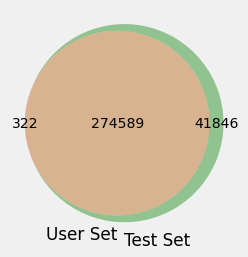

In [30]:
subsets_raw = (set_diff1, set_diff2, set_inter)

venn2(subsets = subsets_raw, 
      set_labels = ('User Set', 'Test Set'))

差集数据相差太大，以至于无法比较差异，我们进行 **`log` 函数缩放**。

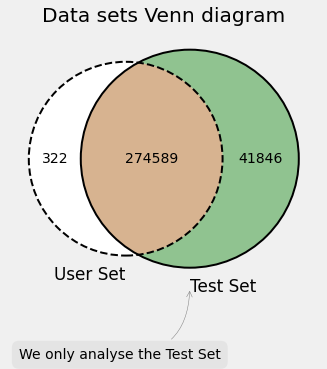

In [31]:
subsets_plot = np.log(subsets_raw)
bit_counter = ('10', '01', '11')

plt.figure(figsize=(5, 5))
v = venn2(subsets=subsets_plot,
          set_labels = ('A', 'B'))

for i in range(3):
    if subsets_raw[i] < 1000:
        v.get_patch_by_id(bit_counter[i]).set_alpha(1.0)
        v.get_patch_by_id(bit_counter[i]).set_color('white')
        
    v.get_label_by_id(bit_counter[i]).set_text(subsets_raw[i])

v.get_label_by_id('A').set_text('User Set')
v.get_label_by_id('B').set_text('Test Set')

c = venn2_circles(subsets=subsets_plot, linestyle='dashed')
# c[1].set_lw()
c[1].set_ls('solid')
plt.title('Data sets Venn diagram')
plt.annotate('We only analyse the Test Set',
             xy=v.get_label_by_id('B').get_position() - np.array([0, 0.05]),
             xytext=(-70, -70), ha='center', textcoords='offset points', 
             bbox=dict(boxstyle='round,pad=0.5', fc='gray', alpha=0.1),
             arrowprops=dict(arrowstyle='->', 
                             connectionstyle='arc3,rad=0.5',
                             color='gray'))
plt.show()

由上图，我们决定去除 `set_diff1`，即空白部分，因其数据量较少，且对后续数据分析无意义，我们重点放在 `test` 数据上面。

因此，采取 `Test Set` >>> _**left join**_ >>> `User Set`。

In [32]:
df_joined = df_test_cleaned.set_index('user_id')\
.join(df_user_cleaned.set_index('user_id')) # left join by default

df_joined

,timestamp,source,device,os,test,price,converted,city,lat,long
user_id,,,,,,,,,,
604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0,Buffalo,42.89,-78.86
624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0,Lakeville,44.68,-93.24
317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0,Parma,41.38,-81.73
685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0,Fayetteville,35.07,-78.90
820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0,Fishers,39.95,-86.02
...,...,...,...,...,...,...,...,...,...,...
17427,2015-04-11 09:29:15,ads_facebook,web,windows,0,39,0,NaN,NaN,NaN
687787,2015-03-16 23:31:55,direct_traffic,web,windows,0,39,0,Bell Gardens,33.97,-118.15
618863,2015-04-11 01:35:19,ads-google,web,mac,0,39,0,West Seneca,42.84,-78.75


### <a name="1.5"></a> 1.5 数据准备

[回到目录](#toc)

终于来到第一阶段的最后部分了，为便于进一步分析，我们将重新分配实验组和对照组数据。

In [33]:
df_joined.groupby('test').size().agg(
    {'count': lambda x: x,
     'prop': lambda x: x / x.sum()        
    }).unstack(level=0)

,count,prop
test,,
0,202517.0,0.639996
1,113918.0,0.360004


<a name="sample-prop"></a> 样本量不平衡，对照组和实验组大致为 64%:36%，接近实验之初所设定的 66%:33%，接着我们按照测试类别 `test` 来重新划分。

In [34]:
df0 = df_joined[df_joined['test']==0] # control group
df1 = df_joined[df_joined['test']==1] # test group

## <a name="2"></a> 2. 随机分配检验

[回到目录](#toc)

- 在一个 A/B 测试中，我们要确保实验组和对照组的分布是接近一致的，即样本的**分配是完全随机**的，比如性别、年龄、实验前使用量等等。（通常我们会先进行一个 A/A 测试来确保不同组用户之间没有偏差。）利有已知数据，我们也可以进行随机分配检验。

- 我们对地理信息 `lat`、`long` (numerical) 和时间序列 `timestamp` (as numeric) 做 [t-test](https://en.wikipedia.org/wiki/Student's_t-test)，测试信息 `source`、`device`、`os` (categorical) 做 [chi-square test](https://en.wikipedia.org/wiki/Chi-squared_test)。

- 如果变量太多，采用**随机森林等树模型**去预测实验组和对照组，可以更好地探索数据间的不平衡，还可以方便得出变量的重要性排序。(试想如果有变量可以帮助我们分辨，那就代表这个变量随机化不够，出现了偏差。）

<sub>(uniqiao.com) 👁‍© just a mark, please ignore it.</sub>

### <a name="2.1"></a> 2.1 数值数据 t-test 检验

[回到目录](#toc)

**检验 `lat` (Latitude)：**

因为 `left join` 之后有部分信息缺失，先进行去除。

In [35]:
lat0 = df0.lat.dropna()
lat1 = df1.lat.dropna()

**观察分布：**

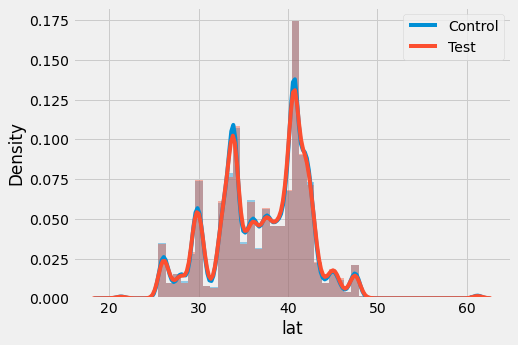

In [36]:
plt.figure(figsize=(7, 5))
sns.distplot(lat0)
sns.distplot(lat1)
plt.legend(labels=['Control', 'Test'])

看起来十分接近，然而还是需要通过统计检验。我们来进行 **t-test**。

<a name="step"></a> **Steps:**

1. 提出原假设和备择假设。
    - H0: 原假设。Latitude 在实验组和对照组分布一致。
    - H1: 备择假设。Latitude 在实验组和对照组分布不一致。
    - 检验为双尾。
2. 确定显著性水平 α。
    - α = 0.05
3. 计算检验统计量。
    - 因为样本量不平衡，采用 [Welch's t-test](https://en.wikipedia.org/wiki/Welch%27s_t-test)
    - $t-statistic = \frac{(mean1 - mean2)}{\sqrt{\frac{var1}{n1} + \frac{var2}{n2}}}$

先手动算一遍：

In [37]:
diff_lat_mean = lat1.mean() - lat0.mean()
diff_lat_mean

0.019823164421573836

In [38]:
se_lat = np.sqrt(lat1.var()/len(lat1) + lat0.var()/len(lat0))
se_lat

0.0204268412195059

In [39]:
# Calculate the 95% Confidence Interval
min_ci_lat = diff_lat_mean - 1.96 * se_lat
max_ci_lat = diff_lat_mean + 1.96 * se_lat
min_ci_lat, max_ci_lat

(-0.020213444368657726, 0.0598597732118054)

In [40]:
t_statistic = diff_lat_mean / se_lat
t_statistic

0.9704468844964828

利用 `scipy.stats` 包进行对比：

In [41]:
stats.ttest_ind(lat1, lat0, equal_var=False)

Ttest_indResult(statistic=0.9704468842793919, pvalue=0.33182493604348573)

**得出结论：**

手动计算的结果与 `scipy.stats` library 相符，可以交叉验证我们的计算是正确的。

  - t-statistic < 1.96
  - p-value > 0.05
  - 95% CI: (-0.02, 0.06)
    
所以我们无法拒绝原假设，分布一致，没有显著性差别。

**检验 `long` (Longitude)：**

同样，我们先去除空值，再绘图。

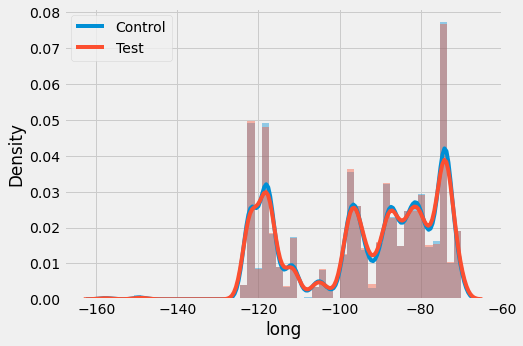

In [42]:
long0 = df0.long.dropna()
long1 = df1.long.dropna()

plt.figure(figsize=(7, 5))
sns.distplot(long0)
sns.distplot(long1)
plt.legend(labels=['Control', 'Test'])

查看分布，与 `lat` 比照，这次红方与蓝方更加势均力敌，说明分布更加一致，p-value 应该更大，让我们来验证猜想。

这次我们利用 `statsmodels` library。

In [43]:
from statsmodels.stats.weightstats import ttest_ind

ttest_ind(long1, long0, usevar="unequal")

(-0.022683242486458793, 0.9819029650202816, 205119.44980741374)

与 `scipy.stats` library 交叉验证。

In [44]:
stats.ttest_ind(long1, long0, equal_var=False)

Ttest_indResult(statistic=-0.022683242486662314, pvalue=0.9819029650201193)

**得出结论：**

p-value 快接近 1 了，可以大胆推定 `long` (Longitude) 分布无显著性差异，我们的猜想（比 `lat` 的 p-value 要大）是正确的，经度比纬度的影响要小。

### <a name="2.2"></a> 2.2 时间序列随机检验

[回到目录](#toc)

因为在 `pandas version 1.1.0` 后，`datetime` type 可以当作 `numeric`，我们不妨也来做下 t-test。

**查看分布：**

有两种方法可以得出每天的测试数据分布。

- 利用 [`dt.date`](https://pandas.pydata.org/docs/reference/api/pandas.Series.dt.date.html) attribute：

In [45]:
df0.groupby(df0.timestamp.dt.date).size().to_frame(name='count')

,count
timestamp,
2015-03-02,1011
2015-03-03,917
2015-03-04,953
2015-03-05,1766
2015-03-06,4602
...,...
2015-05-27,828
2015-05-28,1992
2015-05-29,4402


- 利用 [`resample()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.resample.html) method：

In [46]:
df1.groupby('timestamp').size().to_frame(name='count').resample('D').sum()

,count
timestamp,
2015-03-02,578
2015-03-03,578
2015-03-04,461
2015-03-05,1045
2015-03-06,2600
...,...
2015-05-27,501
2015-05-28,964
2015-05-29,2546


第二种方法相比更加灵活，更好地运用了 pandas 时间序列的特性。我们统一采用第二种。

**数据连接：**

In [47]:
df_day0 = df0.groupby('timestamp').size().to_frame(name='control')\
.resample('D').sum()
df_day1 = df1.groupby('timestamp').size().to_frame(name='test')\
.resample('D').sum()

df_day = pd.concat([df_day0, df_day1], axis=1)
df_day

,control,test
timestamp,,
2015-03-02,1011,578
2015-03-03,917,578
2015-03-04,953,461
2015-03-05,1766,1045
2015-03-06,4602,2600
...,...,...
2015-05-27,828,501
2015-05-28,1992,964
2015-05-29,4402,2546


**绘制时间序列频率图：**

<AxesSubplot:xlabel='timestamp'>

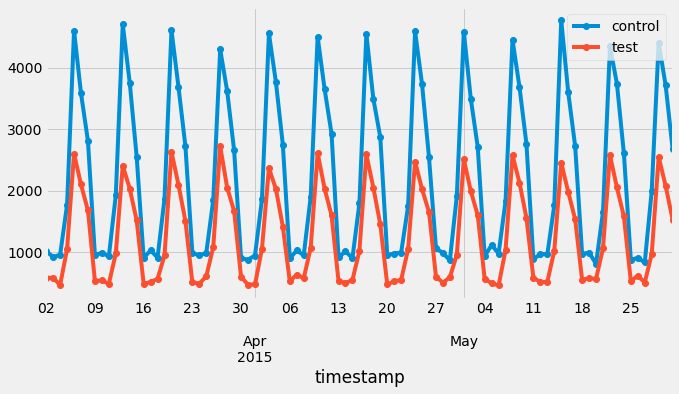

In [48]:
df_day.plot(style='-o', figsize=(10, 5))

很容易发现，数据有 **“周”** 期规律，存在周内变化。

In [49]:
df_day.index.weekday

Int64Index([0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6, 0,
            1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6, 0, 1,
            2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6, 0, 1, 2,
            3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3,
            4, 5, 6],
           dtype='int64', name='timestamp')

根据 [`pandas.DatetimeIndex.weekday`](https://pandas.pydata.org/docs/reference/api/pandas.DatetimeIndex.weekday.html)
> The day of the week with Monday=0, Sunday=6.

我们按周汇总：

In [50]:
df_week = df_day.groupby(df_day.index.weekday).sum()
df_week['sum'] = df_week.sum(axis=1)
df_week.rename(index={0: 'Mon', 1: 'Tue', 2: 'Wed',
                      3: 'Thu', 4: 'Fri', 5: 'Sat',
                      6: 'Sun'}, inplace=True)
df_week

,control,test,sum
timestamp,,,
Mon,12198,7008,19206
Tue,12711,6901,19612
Wed,11977,6851,18828
Thu,23821,13237,37058
Fri,58989,33038,92027
Sat,47536,26630,74166
Sun,35285,20253,55538


**绘制周期分布频率图：**

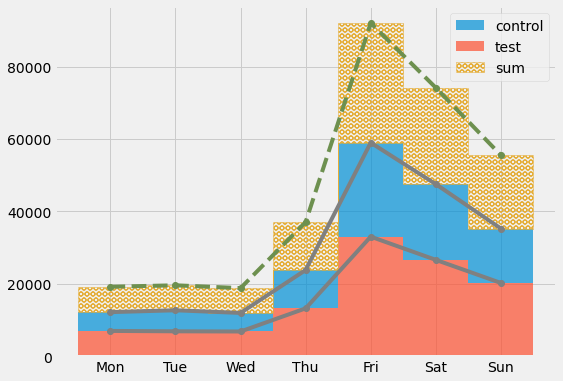

In [51]:
# df_week.plot(style='-o')
# It has been used, let's try some new plots.

xticks = np.arange(0.5, 7.5, 1)

plt.figure(figsize=(8, 6))

# Plot control group
plt.stairs(df_week.control, baseline=df_week.test,
           fill=True, alpha=0.7, label='control')
plt.plot(xticks, df_week.control,
         '-o', color='grey')

# Plot test group
plt.stairs(df_week.test, 
           fill=True, alpha=0.7, label='test')
plt.plot(xticks, df_week.test,
         '-o', color='grey')

# Plot the sum of two
plt.stairs(df_week['sum'], np.arange(0, 8, 1), 
           baseline=df_week.control, 
           orientation='vertical', 
           hatch='OO', label='sum')
plt.plot(xticks, df_week['sum'], 'o--')

plt.legend()
plt.xticks(xticks, df_week.index)
plt.show()

<a name="week-effect"></a> 我们观察到，数据量在周五达到高峰，并延续到周末，呈下降趋势，其他工作日较低。符合人们的娱乐习惯。

实验组和对照组变化趋势相同，分布较一致。我们再来对时间数据分布进行 t-test。

**检验 `timestamp` 时间戳：**

原生的 `datetime` 类型不能使用 `scipy.stats` 检验，我们利用 [`Time deltas`](https://pandas.pydata.org/pandas-docs/stable/user_guide/timedeltas.html) 的 [`total_seconds()`](https://pandas.pydata.org/docs/reference/api/pandas.Timedelta.total_seconds.html#pandas.Timedelta.total_seconds) method 将时间序列转换为数值序列。

In [52]:
date_base = pd.to_datetime('2015-03-02') # set the base date

date0 = (df0.timestamp - date_base).apply(lambda x: x.total_seconds())
date1 = (df1.timestamp - date_base).apply(lambda x: x.total_seconds())

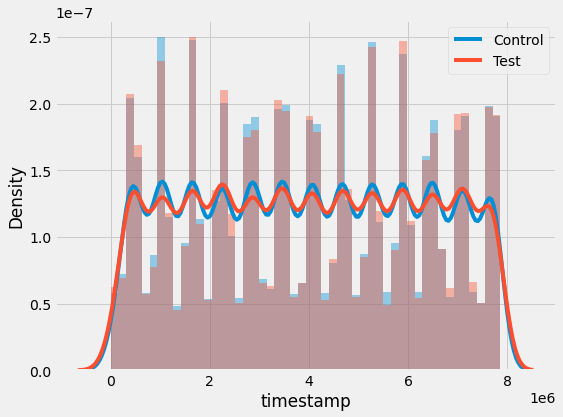

In [53]:
plt.figure(figsize=(8, 6))
sns.distplot(date0)
sns.distplot(date1)
plt.legend(labels=['Control', 'Test'])
plt.show()

<a name="time-series"></a> 可以看出，两者数据分布较一致，实验组波动小于对照组。除了一周内波动，数据在时间上整体分布均匀。

让我们做 t-test 检验：

In [54]:
stats.ttest_ind(date1, date0, equal_var=False)

Ttest_indResult(statistic=1.3502511647178739, pvalue=0.1769367282824994)

**得出结论：**

p-value > 0.05，因此实验组和对照组数据在时间上分布一致。

### <a name="2.3"></a> 2.3 类别数据 chi-square test 检验

[回到目录](#toc)

**检验 `os` (operative_system)：**

先看分组情况。

In [55]:
df_os = df_joined.reset_index().groupby(['test', 'os'])['user_id']\
.count().reset_index()\
.pivot(index='os', columns='test', values='user_id')

df_os

test,0,1
os,,
android,48177,26693
iOS,61793,33560
linux,2204,1926
mac,16345,8710
other,10481,5696
windows,63517,37333


用比例更能看出内部分布，并且按照由大到小进行排序。

In [56]:
df_os_prop = df_os / df_os.sum()
df_os_prop.sort_values(by=[0, 1], ascending=False, inplace=True)
df_os_prop.rename(columns={0: 'control', 1: 'test'}, inplace=True)
df_os_prop.columns.names = ['test_prop']
df_os_prop

test_prop,control,test
os,,
windows,0.313638,0.327718
iOS,0.305125,0.294598
android,0.237891,0.234318
mac,0.080709,0.076459
other,0.051754,0.050001
linux,0.010883,0.016907


根据各自占比画出分布图：

<AxesSubplot:xlabel='os'>

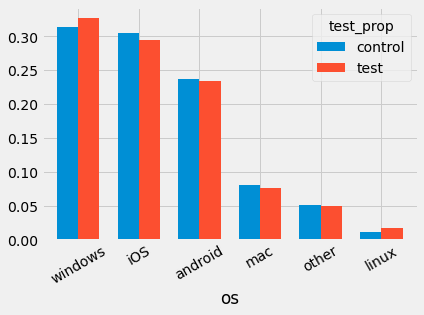

In [57]:
df_os_prop.plot(kind='bar', width=0.7, rot=30)

我们看到实验组和测试组的数据有轻微不同，`linux` 用户数量远远小于其他操作系统，约占 1%，并且在两组数据对比时相差较大。

下面我们将进行 chi-square test，验证 `os` 的分布是否满足随机化。

**Steps:**
1. 提出原假设和备择假设。
    - H0: 原假设。不同类别的操作系统 `os` 在实验组和对照组分布一致。
    - H1: 备择假设。不同类别的操作系统 `os` 在实验组和对照组分布不一致。
2. 确定显著性水平 α。
    - α = 0.05
3. 计算检验统计量。
    - statistic: **χ2 = ∑(Oi – Ei)²/Ei**, where Oi = observed value (actual value) and Ei = expected value.
    - degree of freedom: **df = (r-1)(c-1)**, where r is the number of rows and c is the number of columns.
    - If the observed chi-square test statistic is greater than the critical value, the null hypothesis can be rejected.

按照惯例，先进行手动计算。

变量较多，这次我们进行**矩阵运算**，先生成计算表。

In [58]:
table_os = df_os.T

table_os['total'] = table_os.sum(axis=1)
table_os.loc['total'] = table_os.sum()
table_os.rename(index={0: 'control', 1: 'test'}, inplace=True)

table_os

os,android,iOS,linux,mac,other,windows,total
test,,,,,,,
control,48177,61793,2204,16345,10481,63517,202517
test,26693,33560,1926,8710,5696,37333,113918
total,74870,95353,4130,25055,16177,100850,316435


通过矩阵计算得到期望表：

In [59]:
table_os_exp = table_os.copy()

table_os_exp.loc['control':'test', 'android':'windows'] =      \
table_os.loc['control':'test', 'total'].values.reshape(2, 1) / \
table_os.loc['total', 'total'] *                               \
table_os.loc['total', 'android':'windows'].values.reshape(1, 6)

table_os_exp.columns.names = ['os_exp']
table_os_exp

os_exp,android,iOS,linux,mac,other,windows,total
test,,,,,,,
control,47916.468753,61025.498131,2643.181728,16035.089149,10353.208428,64543.55381,202517
test,26953.531247,34327.501869,1486.818272,9019.910851,5823.791572,36306.44619,113918
total,74870.000000,95353.000000,4130.000000,25055.000000,16177.000000,100850.00000,316435


计算检验统计量：

In [60]:
chi_os = ((table_os - table_os_exp) ** 2 / table_os_exp).sum()

print(chi_os, '\n')
print('The chi-square test statistic is: {0:0.3f}'.format(chi_os.sum()))

os
android      3.934839
iOS         26.812648
linux      202.699961
mac         16.637741
other        4.381488
windows     45.352656
total        0.000000
dtype: float64 

The chi-square test statistic is: 299.819


计算自由度：

In [61]:
dof = (table_os.shape[0] -1 -1) * (table_os.shape[1] -1 -1)
print('The Degree of Freedom is:', dof)

The Degree of Freedom is: 5


接着绘制自由度为 5 的卡方分布图，并设置 p-value 为 0.05：

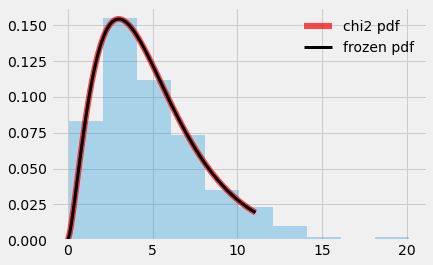

In [62]:
fig, ax = plt.subplots(1, 1)

DoF = dof
# mean, var, skew, kurt = stats.chi2.stats(DoF, moments='mvsk')

x = np.linspace(stats.chi2.ppf(0, DoF),
                stats.chi2.ppf(0.95, DoF), 100) # p-value 0.05 cut off

# Plot line 1
ax.plot(x, stats.chi2.pdf(x, DoF),
        'r-', lw=6, alpha=0.7, label='chi2 pdf')

# Plot line 2
rv = stats.chi2(DoF)
ax.plot(x, rv.pdf(x), 'k-', lw=3, label='frozen pdf')

# Plot hist
r = stats.chi2.rvs(DoF, size=1000)
ax.hist(r, density=True, histtype='stepfilled', alpha=0.3)

ax.legend(loc='best', frameon=False)
plt.show()

可以看到临界值约为 11，与公认的 [Table of χ2 values vs p-values](https://en.wikipedia.org/wiki/Chi-squared_distribution#Table_of_%CF%872_values_vs_p-values) 一致。这远远小于我们得出的检验统计量 299.819，因此有非常大的显著性。

我们再来使用 `scipy.stats` 包来计算，方便得出实验的 p-value。

In [63]:
os0 = df_os[0]
os1 = df_os[1]

stats.chi2_contingency([os0, os1])

(299.8193327610343,
 1.0952307566597536e-62,
 5,
 array([[47916.46875346, 61025.49813074,  2643.18172768, 16035.08914943,
         10353.20842827, 64543.55381042],
        [26953.53124654, 34327.50186926,  1486.81827232,  9019.91085057,
          5823.79157173, 36306.44618958]]))

<a name="chi2"></a> **得出结论：**

p-value 非常小，因此我们有充分的信心推断实验组和对照组的 `os` 分布差异很大，实验设计有问题。

实际上，在设计 A/B 实验过程中，实验组和对照组分布不同很常见，这往往使得整个实验作废。其中首要原因归于随机算法的 bugs 和 bias，使得分配用户到实验组和对照组，容易导致某个细分类别在分组后不能代表其总体分布。比如说，如果实验组有更多的 'iOS' 用户，而 'iOS' 用户总体有更高的转化率，那么测试结果就不仅仅只受测试 feature 的影响了。

不要沮丧，我们继续进行下去，看能不能有新的发现。

**检验 `device`：**

我们直接得出分布比例。

In [64]:
s_device = df_joined['device'].groupby(df_joined['test'])\
.value_counts(normalize=True) # set 'normalize' for proportion
s_device.rename(index={0: 'Control', 1: 'Test'}, inplace=True)
s_device

test     device
Control  mobile    0.594365
         web       0.405635
Test     mobile    0.578469
         web       0.421531
Name: device, dtype: float64

从数值来看，分布比较接近，**But a chart is worth a thousand numbers, if not, two!**

我们定义一个自动标注分布比例的函数：

In [65]:
def annotate_with_hue(plot, feature, Number_of_categories, hue_categories):
    a = [p.get_height() for p in plot.patches]
    patch = [p for p in plot.patches]
    for i in range(Number_of_categories):
        total = feature.value_counts().values[i]
        for j in range(hue_categories):
            percentage = '{:.1f}%'.format(100 * a[(j*Number_of_categories + i)]/total)
            x = patch[(j*Number_of_categories + i)].get_x() + \
                patch[(j*Number_of_categories + i)].get_width() / 2 - 0.15
            y = patch[(j*Number_of_categories + i)].get_y() + \
                patch[(j*Number_of_categories + i)].get_height() 
            ax.annotate(percentage, (x, y))
    plt.show()

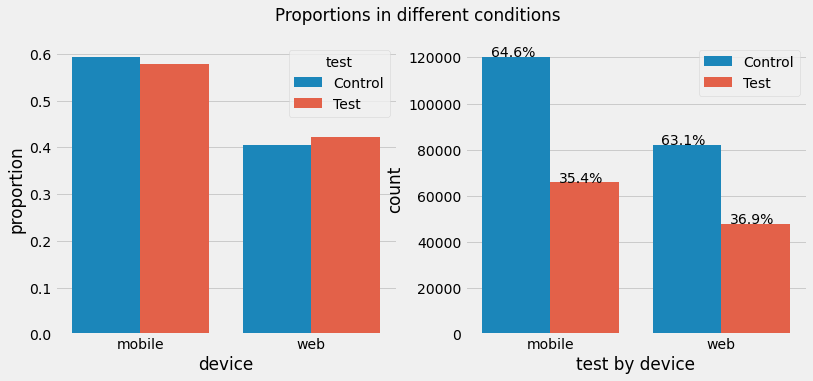

In [66]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('Proportions in different conditions')

(s_device
.rename('proportion')
.reset_index()
.pipe((sns.barplot, 'data'), 
       x='device', y='proportion',
       hue='test', ax=ax1))

ax = sns.countplot('device', hue='test', data=df_joined, ax=ax2)
ax.legend(labels=['Control', 'Test'])
ax.set_xlabel('test by device')
annotate_with_hue(ax, df_joined.device, 2, 2)

- 左图，设备类型 `device` 在对照组和实验组的分布，可以看到差异。在 `moblie` 中对照组占比高于实验组，而到了 `web` 端就反过来了。

- 右图，实验类型 `test` 在设备类型 (`mobile` or `web`) 的分布，应该服从总体样本分布 [64%:36%⇱](#sample-prop) 才对，而这里表现了轻微差异。

直接调用 `scipy.stats` 来计算：

In [67]:
device0 = df0.groupby('device').size()
device1 = df1.groupby('device').size()

stats.chi2_contingency([device0, device1])

(76.01682303027343,
 2.8125833608921354e-18,
 1,
 array([[119210.0559009,  83306.9440991],
        [ 67056.9440991,  46861.0559009]]))

**得出结论：**

p-value 也非常小，意味着 `device` 的分布也不同。考虑到 `device` 和 `os` 关系密切（包含关系），便在情理之中了。

**检验 Source：**

先看分组情况，由大到小排列。

In [68]:
df_source = df_joined.groupby(['test', 'source']).size().unstack('test')
df_source.sort_values(by=[0, 1], ascending=False, inplace=True)
df_source.rename(columns={0: 'control', 1: 'test'}, inplace=True)
df_source

test,control,test
source,,
direct_traffic,38712,21560
ads-google,37845,21497
ads_facebook,34074,19281
ads_other,19256,10570
seo-google,15088,8060
ads-bing,14584,8247
seo_facebook,13461,7722
friend_referral,13121,7557
seo-other,5879,3365


同样，用各自占比可以更好判断。绘图如下：

<AxesSubplot:ylabel='source'>

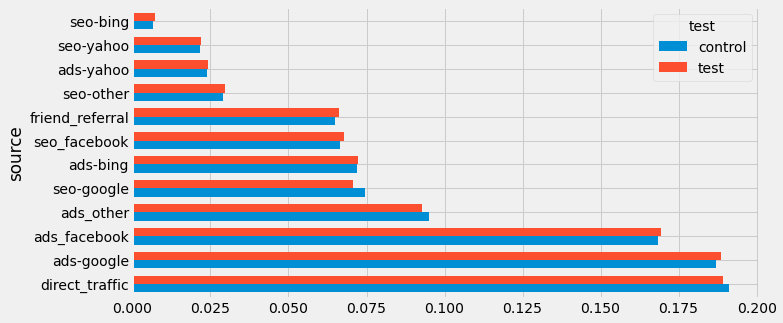

In [69]:
(df_source/df_source.sum()).plot(kind='barh', figsize=(10, 5), width=0.7)

可以发现，分布多数有轻微差异。我们利用 `scipy.stats` 来判断：

In [70]:
source0 = df_source.control
source1 = df_source.test

stats.chi2_contingency([source1, source0])

(31.28629188016634,
 0.0009919073629335513,
 11,
 array([[21698.18666077, 21363.38254618, 19208.03605796, 10737.49195885,
          8333.38241345,  8219.26101095,  7625.97371972,  7444.17148546,
          3327.88089813,  2725.59349629,  2462.79026656,   771.84948568],
        [38573.81333923, 37978.61745382, 34146.96394204, 19088.50804115,
         14814.61758655, 14611.73898905, 13557.02628028, 13233.82851454,
          5916.11910187,  4845.40650371,  4378.20973344,  1372.15051432]]))

**得出结论：**

p-value < 0.05，说明渠道来源 `source` 分布也不同，只是显著性没有前面两者大。（猜测 `os`、`device`、`source` 三个变量互不独立。）

### <a name="2.4"></a> 2.4 利用树模型检验

[回到目录](#toc)

**数据处理：**

1. 首先确定 label 为 `test`，即预测是否出现在实验组。
2. 接着去除无用变量，即与预测不相关的字段。
3. 然后处理类别型变量，我们采用 pandas `get_dummies` 函数。

In [71]:
# Drop useless columns, note that 'test' is the desired label
drop_cols = ['timestamp', 'test', 'price', 'converted', 'lat', 'long']
df_train = df_joined.drop(drop_cols, axis=1).fillna(0)

# convert categorical vars to dummies
train_cols = ['source', 'device', 'os', 'city']
df_train = pd.get_dummies(df_train, train_cols)

由于 label 是类别型，我们使用分类树。

In [72]:
df_label = df_joined['test'] # set the predict lable

clf = tree.DecisionTreeClassifier(
    class_weight='balanced',
    max_depth=2,             # limit output
    random_state=seed)

clf.fit(df_train, df_label)

DecisionTreeClassifier(class_weight='balanced', max_depth=2, random_state=2022)

**可视化决策树：**

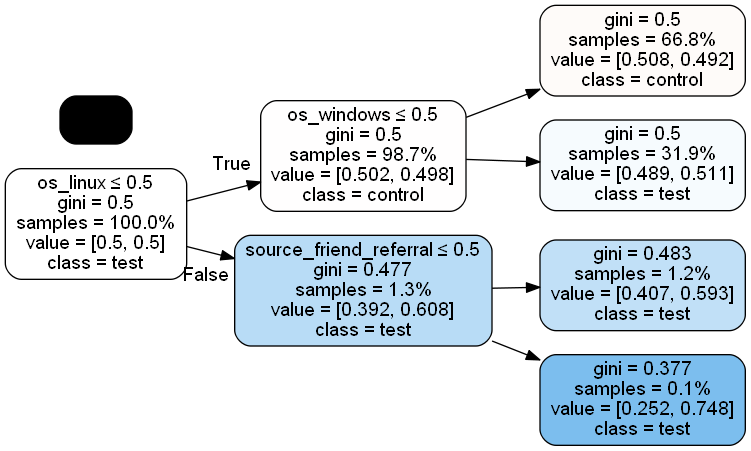

In [73]:
dot_data = tree.export_graphviz(clf, 
                                out_file=None,
                                feature_names=df_train.columns,
                                class_names=['control', 'test'],
                                filled=True,
                                rounded=True,
                                special_characters=True,
                                proportion=True,
                                rotate=True)

graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

如图，颜色越冷（蓝），分到实验组的概率越大。我们注意到 `linux` (0.608 > 0.392) 和 `windows` (0.511 > 0.489) 的用户都有较高的几率分配到实验组，其中在 `linux` 用户中， `friend_referral` (0.748 > 0.252) 则更有可能出现在实验组中。

**聚木成林：**

采用**随机森林**模型。由于 `city` 的类别过多 (922 个)，严重拖慢训练进程，且我们已经对地理信息 (`lat`&`long`) 检验过随机化了，因此在训练复杂模型时予以去除。

In [74]:
rfclf = RandomForestClassifier(random_state=seed)

rf_cols = ['source', 'device', 'os']
df_rf = pd.get_dummies(df_joined[rf_cols])

rfclf.fit(df_rf, df_label)

RandomForestClassifier(random_state=2022)

得到特征的重要性，并进行排序。

In [75]:
features = [x for _, x in sorted(zip(
    rfclf.feature_importances_, df_rf.columns))]
importances = [_ for _, x in sorted(zip(
    rfclf.feature_importances_, df_rf.columns))]

进行可视化：

Text(0.5, 0, 'importances')

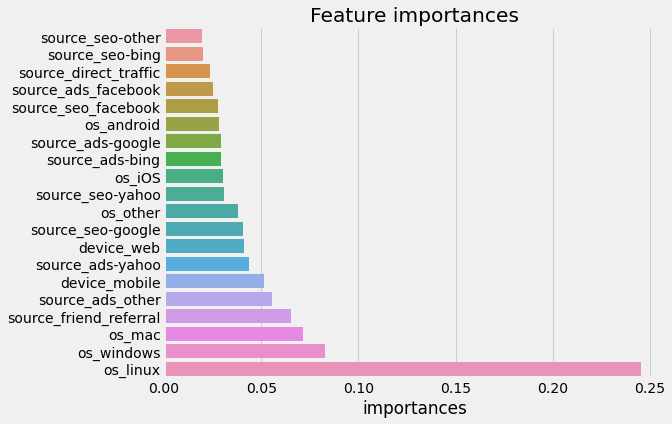

In [76]:
plt.figure(figsize=(8, 6))

sns.barplot(importances, features)

plt.title('Feature importances')
plt.xlabel('importances')

<a name="feat-importances"></a> 通过特征重要性排序，我们发现 `os` 操作系统下的变量 `linux`、`windows`、`mac` 占据了前三甲。其中，`linux` 的重要性远大于其它变量。这说明 `linux` 用户更有可能被分配到实验组。

**总结：**

基于树模型，我们找到了导致分布不一致的影响因子，进一步验证了实验没有实现理想的随机分配。其中 `os` 分类表现突出，而里面的 `linux` 变量更是不寻常，有待进一步考察。

## <a name="3"></a> 3. 怎么定价

[回到目录](#toc)

当然不是拍脑门决定的，我们还是要通过统计检验来做出决策。下面给出简单的 "How to Choose" 流程图：

![Stat Tests Flow Chart](images/stat_tests_flowchart.png)

我们要检验的属于 `quantitative (Revenue) ~ categorical (groups or segments)`，因此采用 `two samples t-test`。

- 先针对所有用户进行 t-test，检验不同价格是否会影响整体的营收。

- 然后再对不同细分群体的营收做 t-test，观察价格对不同用户群体的影响。

### <a name="3.1"></a> 3.1 整体分析

[回到目录](#toc)

和 [之前的步骤⇱](#step) 一样，我们先设立原假设——价格不影响整体营收，选定 α = 0.05，即犯第一类错误的概率为 5%，再计算 t-statistic。

查看每组的转化率和平均营收，其中营收为价格与转化率之积。

In [77]:
df_rev = df_joined[['price', 'converted']].copy()
df_rev['revenue'] = df_rev.prod(axis=1)

table_rev = df_rev.groupby('price')[['converted', 'revenue']].mean()
table_rev

,converted,revenue
price,,
39,0.019900,0.776083
59,0.015555,0.917748


Again, a chart is worth a thousand numbers, if not, **two!**

Text(0.5, 0, 'Revenue Avg.')

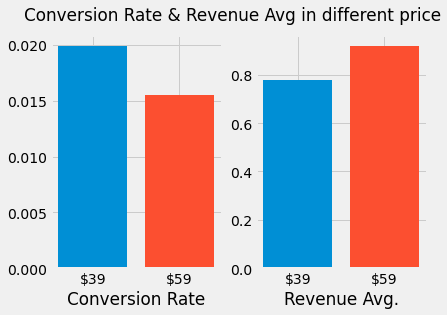

In [78]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Conversion Rate & Revenue Avg in different price')

ax1.bar(0, height=table_rev.converted.loc[39])
ax1.bar(1, height=table_rev.converted.loc[59])
ax1.set_xticks([0, 1])
ax1.set_xticklabels(['$39', '$59'])
ax1.set_xlabel('Conversion Rate')

ax2.bar(0, height=table_rev.revenue.loc[39])
ax2.bar(1, height=table_rev.revenue.loc[59])
ax2.set_xticks([0, 1])
ax2.set_xticklabels(['$39', '$59'])
ax2.set_xlabel('Revenue Avg.')

<a name="all-test"></a> 从上图得知，\$59 的实验组在转化率更低的情况下，平均营收更高。

那么“更高的平均营收”能否通过统计检验呢？让我们来做 t-test：

In [79]:
revenue0 = df0['converted'] * 39 # control
revenue1 = df1['converted'] * 59 # test

test_rev = stats.ttest_ind(revenue1, revenue0, equal_var=False)
test_rev

Ttest_indResult(statistic=5.715224666463108, pvalue=1.0972577312420781e-08)

可以看到，p-value 非常小，也就是说原假设几乎不可能成立，足以说明价格因素会影响营收水平。

注意，我们做的是双尾检验，如果想要验证“提高价格会增加营收”，那么 p-value 还要除以 2：

In [80]:
print("One-tail p-value:", test_rev.pvalue / 2)

One-tail p-value: 5.486288656210391e-09


**得出结论：**

实验组的平均营收显著性大于对照组，即提高价格会增加营收。

### <a name="3.2"></a> 3.2 细分群体

[回到目录](#toc)

然而，我们不能就这样轻易地下决定，还记得我们在进行 [chi-squre test ⇱](#chi2) 时发现实验并不满足随机化要求。因此，再观察这些分布差异明显的细分群体，检验结论是否依然成立，是一个更好的方案，**more robust!**

先整理我们所需的变量（分布有显著差异的），即 `source`, `device`, `os`：

In [81]:
df_rev_seg = df_joined[['source', 'device', 'os', 'price', 'converted']].copy()
df_rev_seg['revenue'] = df_rev_seg[['price', 'converted']].prod(axis=1)
df_rev_seg.describe(include='all')

,source,device,os,price,converted,revenue
count,316435,316435,316435,316435.000000,316435.000000,316435.000000
unique,12,2,6,NaN,NaN,NaN
top,direct_traffic,mobile,windows,NaN,NaN,NaN
freq,60272,186267,100850,NaN,NaN,NaN
mean,NaN,NaN,NaN,46.200088,0.018336,0.827083
std,NaN,NaN,NaN,9.600041,0.134162,6.179009
min,NaN,NaN,NaN,39.000000,0.000000,0.000000
25%,NaN,NaN,NaN,39.000000,0.000000,0.000000
50%,NaN,NaN,NaN,39.000000,0.000000,0.000000
75%,NaN,NaN,NaN,59.000000,0.000000,0.000000


**`source` 分析：**

定义 `lambda` ，方便计算 p-value：

In [82]:
lambda_pvalue = lambda x: stats.ttest_ind(x[df_rev_seg['price']==39],
                                          x[df_rev_seg['price']==59],
                                          equal_var=False).pvalue / 2
                         # note should divided by 2 for one-tail test

数据透视，这次我们来个复杂度更高的：

In [83]:
df_rev_seg.groupby('source')['revenue', 'converted'].agg([
    ('Count', 'count'),
    ('Control', lambda x: x[df_rev_seg['price']==39].mean()),
    ('Test', lambda x: x[df_rev_seg['price']==59].mean()),
    ('p-value', lambda_pvalue)
]).sort_values(by=[('revenue', 'p-value'), ('converted', 'p-value')])

revenue                               converted            \
                  Count   Control      Test   p-value     Count   Control   
source                                                                      
ads-google        59342  0.880063  1.158208  0.000006     59342  0.022566   
seo-google        23148  0.682397  0.944293  0.002297     23148  0.017497   
friend_referral   20678  1.625867  1.975255  0.006224     20678  0.041689   
ads_other         29826  0.601527  0.731220  0.036479     29826  0.015424   
direct_traffic    60272  0.526891  0.596568  0.066002     60272  0.013510   
seo_facebook      21183  0.680856  0.802253  0.087163     21183  0.017458   
seo-bing           2144  1.173815  0.796319  0.104696      2144  0.030098   
ads_facebook      53355  0.922522  0.994502  0.128221     53355  0.023654   
seo-yahoo          6841  0.761019  0.617304  0.161784      6841  0.019513   
ads-bing          22831  0.521462  0.565175  0.275622     22831  0.013371   
seo-other          9244  0.683279  0.736404  0.342756      9244  0.017520   
ads-yahoo          7571  0.656484  0.662921  0.481499      7571  0.016833   

                                         
                     Test       p-value  
source                                   
ads-google       0.019631  7.887786e-03  
seo-google       0.016005  1.980895e-01  
friend_referral  0.033479  1.212665e-03  
ads_other        0.012394  1.494152e-02  
direct_traffic   0.010111  7.858960e-05  
seo_facebook     0.013598  1.306405e-02  
seo-bing         0.013497  3.697611e-03  
ads_facebook     0.016856  2.101167e-08  
seo-yahoo        0.010463  9.943511e-04  
ads-bing         0.009579  4.090031e-03  
seo-other        0.012481  2.487579e-02  
ads-yahoo        0.011236  2.029560e-02

**得出结论：**

我们发现，转化率除了 `seo-google` 不具有显著性外，其他渠道对照组均高于实验组，考虑到价格与转化率负相关，便不足为奇了。

而到了平均营收，结论似乎恰好相反，大多数营销渠道实验组都要高于对照组，其中 `ads-google`, `seo-google`, `friend_referral`, `ads_other` 四组具有显著性。

**`os` 分析：**

同样的方法得到数据透视表：

In [84]:
df_rev_seg.groupby('os')['revenue', 'converted'].agg([
    ('Count', 'count'),
    ('Control', lambda x: x[df_rev_seg['price']==39].mean()),
    ('Test', lambda x: x[df_rev_seg['price']==59].mean()),
    ('p-value', lambda_pvalue)
]).sort_values(by=[('revenue', 'p-value'), ('converted', 'p-value')])

revenue                                   converted            \
          Count   Control      Test       p-value     Count   Control   
os                                                                      
linux      4130  0.601633  0.000000  2.433772e-09      4130  0.015426   
iOS       95353  0.920201  1.179648  1.809632e-07     95353  0.023595   
mac       25055  0.992597  1.253157  5.730053e-03     25055  0.025451   
windows  100850  0.729443  0.826534  9.746832e-03    100850  0.018704   
android   74870  0.637088  0.729405  2.197252e-02     74870  0.016336   
other     16177  0.546990  0.652563  1.287612e-01     16177  0.014025   

                                 
             Test       p-value  
os                               
linux    0.000000  2.433772e-09  
iOS      0.019994  1.160468e-04  
mac      0.021240  1.654330e-02  
windows  0.014009  3.677115e-09  
android  0.012363  3.973605e-06  
other    0.011060  4.977366e-02

**得出结论：**

- 这次我们发现了一个亮眼的变量——又是 `linux`！在实验组中转化率和平均营收都为零。

- 其他的变量，服从总体趋势，即实验组转化率低而平均营收高。

单独将 `linux` 拧出来：

In [85]:
df_rev_seg.groupby(['os','converted']).size()['linux']\
.rename({0: 'Not converted', 1: 'Converted'})

converted
Not converted    4096
Converted          34
dtype: int64

`linux` 总体转化数也极少。

我们生成数据透视表并黄色标记转化数较低的可疑数值，再标红其中最小值：

In [86]:
df_rev_seg.groupby(['os', 'price']).converted.sum().to_frame()\
.style.highlight_quantile(axis=0, q_right=0.1, color='yellow')\
      .highlight_min(color='red')

可以发现，相比其他操作系统，`linux` 转化数是最低的，而当价格为 \$59 时，就不存在转化了。

为了验证这是不是随机现象，我们再来做假设检验：

In [87]:
linux0 = df_rev_seg.converted[(df_rev_seg.os=='linux') & \
                              (df_rev_seg.price==39)] # control
linux1 = df_rev_seg.converted[(df_rev_seg.os=='linux') & \
                              (df_rev_seg.price==59)] # test

# We test in another way, the 'statsmodels' library
# from statsmodels.stats.weightstats import ttest_ind
"p-value: {}".format(ttest_ind(linux0, linux1, usevar="unequal")[1])

'p-value: 4.86754486894385e-09'

p-value 极小，所以在实验组必然出现了问题。可能存在 bug 比如无法支付，也可能 `linux` 这个用户群体本身对价格极度敏感，而产品没有切中他们的要点。

**`device` 分析：**

In [88]:
table_device = \
df_rev_seg.groupby('device')['revenue', 'converted'].agg([
    ('Count', 'count'),
    ('Control', lambda x: x[df_rev_seg['price']==39].mean()),
    ('Test', lambda x: x[df_rev_seg['price']==59].mean()),
    ('p-value', lambda_pvalue)
]).sort_values(by=[('revenue', 'p-value'), ('converted', 'p-value')])

table_device

revenue                                   converted            \
         Count   Control      Test       p-value     Count   Control   
device                                                                 
mobile  186267  0.775017  0.952624  3.505491e-08    186267  0.019872   
web     130168  0.777645  0.869888  7.098841e-03    130168  0.019940   

                                
            Test       p-value  
device                          
mobile  0.016146  2.179332e-09  
web     0.014744  7.911246e-13

**得出结论：**

`mobile` 和 `web` 均与[总体检验⇱](#all-test)一致，由于变量较少，我们可以方便地画图分析：

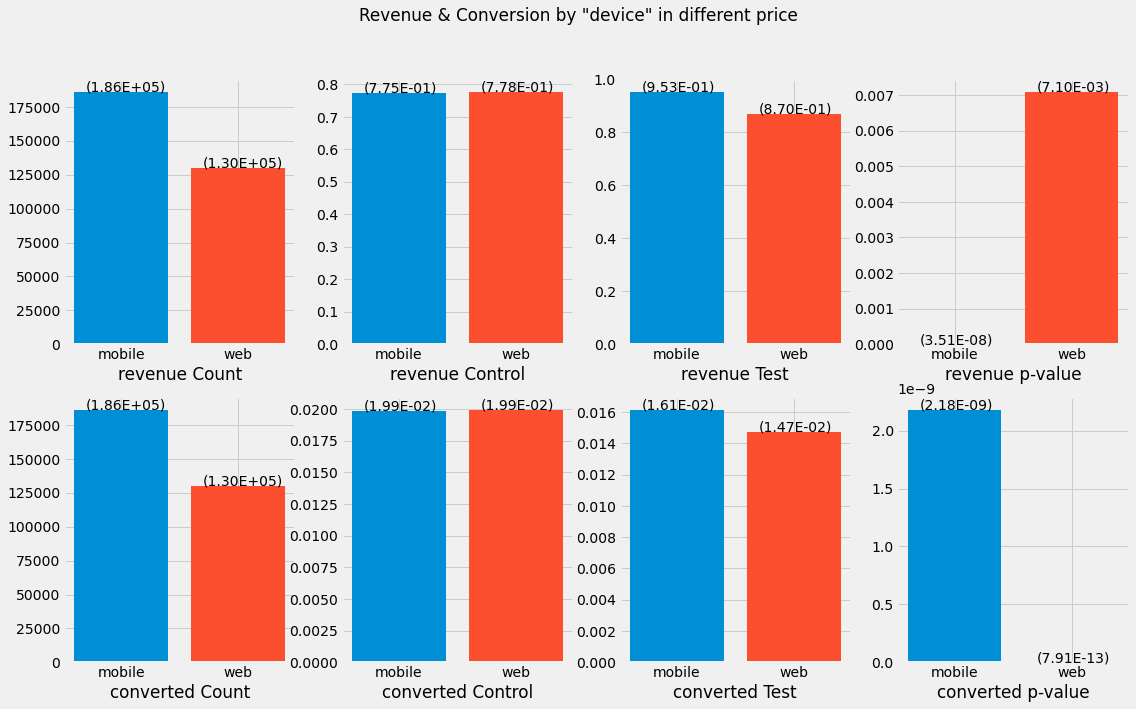

In [89]:
fig, axs = plt.subplots(2, 4, figsize=(17, 10))

fig.suptitle('Revenue & Conversion by "device" in different price')

for i in range(2):
    for j in range(4):
        axs[i, j].bar(0, height=table_device.iloc[0, i*4 + j])
        axs[i, j].bar(1, height=table_device.iloc[1, i*4 + j])
        axs[i, j].set_xticks([0, 1])
        axs[i, j].set_xticklabels(['mobile', 'web'])
        axs[i, j].set_xlabel(' '.join(table_device.columns[i*4 + j]))
        
        for p in axs[i, j].patches:
            v = '({0:0.2E})'.format(p.get_height())
            x = p.get_x() + p.get_width() - 0.7
            y = p.get_y() + p.get_height()
            axs[i, j].annotate(v, (x, y))

Now it comes to 8 charts, just by one plot! That's pretty crazy, I would say.

<a name="device"></a> 不要被图多乱眼，因为不同图表的量纲不同，这点需要注意。

上面这些图表主要进行的是 `mobile` 和 `web` 在各个不同指标之间的对比，其中营收和转化率正相关，这点由定义不能发现。

重点观察两组的平均营收情况 `revenue`，可以发现在对照组中，营收水平几乎持平，而到了实验组中，通过提高价格，手机端 `mobile` 平均营收超过了网页端 `web`，利用经济学基本知识，这说明 `mobile` 用户对价格没有 `linux` 用户敏感，平时生活中，“大数据杀熟”也更容易出现在手机端应用上。

### <a name="3.3"></a> 3.3 最终结论

[回到目录](#toc)

- 通过整体分析，实验组平均营收显著性高于对照组，价格优化策略具有统计学意义上的成功。
- 考虑到实验分组时没有实现完全的随机分配，针对分布有差异的变量分别单独进行假设检验。
  1. 之前使用随机森林得到了[变量的重要性排序⇱](#feat-importances)，也就是变量在分组时的不随机程度。操作系统 `os` 这个类别表现突出，其中 `linux` 尤为突出。
  2. 在对 `os` 细分群体进行检验时发现，`linux` 用户对整体的贡献最低，而在实验组中直接为零。
  3. 在 `linux` 用户更有可能出现在实验组，却没有任何贡献拖后腿的情况下，实验组整体营收水平仍高于对照组。
  4. 因此，我们可以推定提高价格可以提高整体营收，价格策略是成功的。
- 然而回到实验本身，我们不能说这是个成功的实验，因为没有在理想的情况下进行。因此对实验的评估如下：
  1. **如果可以的话，最好再重新进行 A/B 测试，并实现更好的随机化，消除数据分布差异。**
  2. **如果成本不允许的话，可以接受实验结果，\$59 是更好的定价。**

## <a name="4"></a> 4. 何时结束

[回到目录](#toc)

何时结束，即应该采用多少样本量，这就是一个 Sample Size 问题。

确定样本量也很重要，太少就看不到效果，太多的话会冒着影响很多用户体验的风险，以及占用团队宝贵的资源。

在设计 A/B 实验时，我们就应该事先计算出，为得到具备统计功效的结果，所需实验的样本最小量。其实也有一些在线工具帮助我们方便计算，如 [Evan's Awesome A/B Tools - Sample Size Calculator](https://www.evanmiller.org/ab-testing/sample-size.html)。这个网站评估的是 Converion rate 比例指标，这是一种结果为 (0, 1) 的二点分布问题，而我们在意的是 Revenue 这个数值型指标。

先算出 `revenue` 指标的统计信息：

In [90]:
df_rev_stats = df_rev.groupby('price')['revenue'].agg('describe')
df_rev_stats.rename(index={39: 'Control', 59: 'Test'}, inplace=True)
df_rev_stats.index.name = 'Test Type'
df_rev_stats.columns.name = 'Revenue stats'
df_rev_stats

Revenue stats,count,mean,std,min,25%,50%,75%,max
Test Type,,,,,,,,
Control,202517.0,0.776083,5.446566,0.0,0.0,0.0,0.0,39.0
Test,113918.0,0.917748,7.301050,0.0,0.0,0.0,0.0,59.0


### <a name="4.1"></a> 4.1 计算样本量

[回到目录](#toc)

**Steps:**

1. 设定阈值。
  - Minimun Detective Effect: MDE = 10%. 我们期待能在实验中观察到的最小变化，尽管只要变化是有利的，我们都乐于接受，然而过于小我们就很难检验到了，以及需要更多的样本量，消耗更多的资源，不值得为之进行。
  - Type I errors: ⍺ = 0.05。拒真的概率，在我们实验中指，实际上定价 \$39 还是 \$59 都不影响营收，而我们却拒绝了这个假设的概率，认为不同定价有影响。因为阈值已经很小了，如果再低于这个阈值，那我们就认为是不可能事件，此时应该拒绝原假设。
  - Type II errors：β = 0.20 (Power=1-β=0.80)。取伪的概率，在我们实验中指，实际上定价 \$39 还是 \$59 确实会影响营收，而我们却认为不影响，即检验不到想要的最小变化的概率。
2. 已知数据。
  - Baseline: 实验前的营收水平，即 revenue per user。这里我们并不知道，所以在对照组中算出。
  - 对照组的标准差。
  - 实验组的标准差。（实验前也可以推估，这里我们利用已有实验数据）  
3. 确定假设。
  - H0: Test revenue - Control revenue < MDE * 0.776（0.776 由上表得出）
  - H1: Test revenue - Control revenue >= MDE * 0.776
4. 计算样本量。
  - 计算临界值 Critical Value (C)，即下图中红线。
  - 计算 Standard Error (SE)， 注意和 Standard Deviation (SD) 的区别。
  - 计算样本量 Sample Size，我们最终要的结果。

![Power AB](images/Power-AB.png)
<cite>Source: <a href="https://www.linkedin.com/in/trchan/">Timothy Chan</a></cite>

我们这里利用 Python 的符号运算包 `SymPy` 解方程，其中 p-value 由 `scipy.stats` 得出，根据上图计算 ⍺ 和 β 面积：

In [91]:
from sympy import *

C = Symbol('C')
SE = Symbol('SE')

alpha = 0.05
beta = 0.20

control_rev = df_rev_stats.loc['Control', 'mean']
mde = control_rev * 0.1

c_value, s_error = solve(
    [C - stats.norm.ppf(1 - alpha) * SE, 
     mde - C - stats.norm.ppf(1 - beta) * SE],
    [C, SE]).values()

display('Critical Value:', c_value,
        'Standard Error:', s_error)

'Critical Value:'

0.0513394665770710

'Standard Error:'

0.0312121794522363

计算样本量： ![sample calculation](images/sample-calculation.png)

In [92]:
control_std = df_rev_stats.loc['Control', 'std']
test_std = df_rev_stats.loc['Test', 'std']

prop_count = df_rev_stats.loc['Control', 'count'] / \
             df_rev_stats.loc['Test', 'count']

N = Symbol('N')

sample_test = solve(
    [control_std**2 / (N * prop_count) + \
     test_std**2 / N - s_error**2],
    [N])[N]

display('Sample Test:', math.ceil(sample_test))

'Sample Test:'

71846

我们计算出最小样本量 `71,846`，也就是我们要测试的用户数。（需要注意的是，产品团队原本设计的是按照 对照组:实验组 = 66%:33%，而实际比例有小量差异，这里我们按照实际数据比例来计算。）

在数据有效的情况下，这个数目足以检验出结果。

### <a name="4.2"></a> 4.2 计算终止时期

[回到目录](#toc)

现在我们回到时间因素上，何时可以停止实验？

还记得我们之前得出的结论吗？[数据在时间上呈周期性均匀分布⇱](#time-series)，所以样本量可以按照时间段分割，同时要兼顾**“周”**期规律。

利用 pandas [`rank()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rank.html) 方法将测试数据按时间先后顺序重新排列。这里我们传递参数 `method='first'` 以便得到整数排序。

In [93]:
time_rank = df1['timestamp'].rank(method='first')
time_rank

user_id
685636    80502.0
798371    16248.0
447194    32665.0
431639    65365.0
552048    25083.0
           ...   
190563    95416.0
796427    37111.0
964001    79724.0
388438    97538.0
832372     8733.0
Name: timestamp, Length: 113918, dtype: float64

定位到我们要终止的时期。

In [94]:
timestamp_loc = math.ceil(sample_test)

sample_loc = time_rank[time_rank==timestamp_loc]

end_loc = df1.loc[sample_loc.index] # what we want is the Index
end_loc

,timestamp,source,device,os,test,price,converted,city,lat,long
user_id,,,,,,,,,,
104571,2015-04-30 02:19:03,seo-yahoo,web,windows,1,59,0,Pine Hills,28.58,-81.46


判断出那天是星期几。

In [95]:
end_date = end_loc.timestamp[0]
print("End at {}".format(end_date) +
      "\n" +
      "Day {} of the week".format(end_date.dayofweek + 1))

End at 2015-04-30 02:19:03
Day 4 of the week


与实验开始日期相比较。

In [96]:
start_date = df1.timestamp.min()
print("Start at {}".format(start_date) +
      "\n" +
      "Day {} of the week".format(start_date.dayofweek + 1))

Start at 2015-03-02 00:04:12
Day 1 of the week


In [97]:
end_date - start_date

Timedelta('59 days 02:14:51')

**最终结论：**

- 我们看到实验于三月初周一开始，四月最后一天周四结束，并没有经历后面三天（周五、周六、周日）一周中的高峰期。因此为了兼顾 [周内变化⇱](#week-effect)，测试周期应完整，建议实验于 **`05-03`** 终止。

- 当然，如果公司习惯以月为单位的话，也可以在四月底 **`04-30`** 结束实验，毕竟不考察周内变化的话，样本量已经够了。

## <a name="5"></a> 5. 数据总览

[回到目录](#toc)

前面我们对实验本身做了大量数据分析工作，包括清理数据、数据可视化、假设检验等等，已经走完了一个完整的 A/B 测试流程。

现在，我们将跳出这个实验，观察数据本身。— A Holistic View of Data

### <a name="5.1"></a> 5.1 转化率考察

[回到目录](#toc)

转化率与公司营收息息相关。因此，我们重点放在这上面考察。

在跳出统计学严谨的框架后，这时候**机器学习**就可以轻松上阵了。

为找出影响转化率的重要因子，我们决定还是采用树模型，无它，简单高效。

In [98]:
df_joined.sample(1, random_state=seed)

,timestamp,source,device,os,test,price,converted,city,lat,long
user_id,,,,,,,,,,
366323,2015-03-25 02:28:04,seo-google,mobile,iOS,0,39,0,NaN,NaN,NaN


回到我们最初清理好的数据集上。

**训练模型：**

In [99]:
# Drop useless columns, note that 'converted' is the desired lavbel
df_train_converted = df_joined.drop(['converted', 'timestamp', 
                                     'test', 'lat', 'long'],
                           axis=1).fillna(0)
df_train_converted = pd.get_dummies(df_train_converted, 
                           ['source', 'device', 'os', 'city'])

In [100]:
tree_converted = tree.DecisionTreeClassifier(
    max_depth=3, random_state=seed)
tree_converted.fit(df_train_converted, df_joined['converted'])

DecisionTreeClassifier(max_depth=3, random_state=2022)

**可视化决策树：**

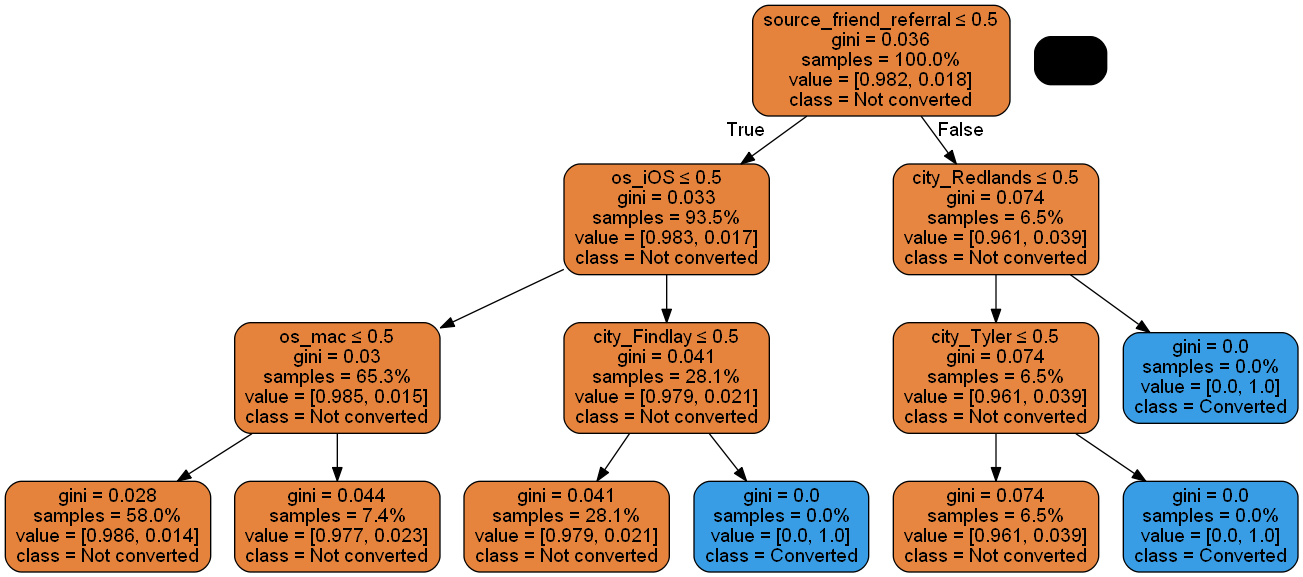

In [101]:
dot_data_converted = tree.export_graphviz(tree_converted,
                                          out_file=None, 
                                          feature_names=
                                          df_train_converted.columns,
                                          class_names=['Not converted',
                                                       'Converted'],
                                          filled=True,
                                          rounded=True,
                                          special_characters=True,
                                          proportion=True)

graph_converted = pydotplus.graph_from_dot_data(dot_data_converted)
Image(graph_converted.create_png())

<a name="tree-nodes"></a> 为了便于展示，和加快模型训练，我们只生成到第三层，由此可以一窥究竟，变量重要性排序如下：

In [102]:
pd.Series(tree_converted.feature_importances_,
          index=df_train_converted.columns)\
.sort_values(ascending=False).head()

source_friend_referral    0.597015
os_iOS                    0.124129
os_mac                    0.095978
city_Findlay              0.062465
city_Tyler                0.060209
dtype: float64

我们发现，经 `friend_referral` 渠道的流量更容易转化，此外苹果生态系统 `iOS`、`mac` 用户也较愿意为我们产品付费。

**`source` & `os`:**

绘制转化率条形图进行验证：

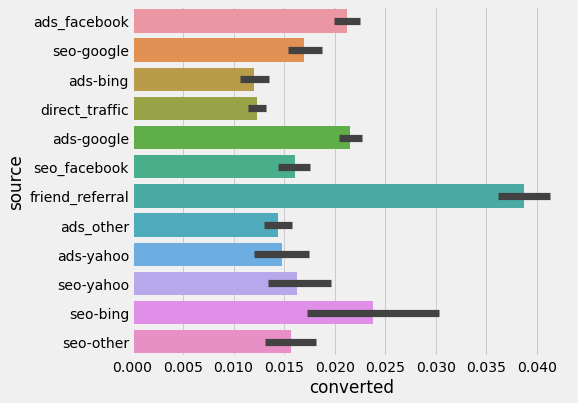

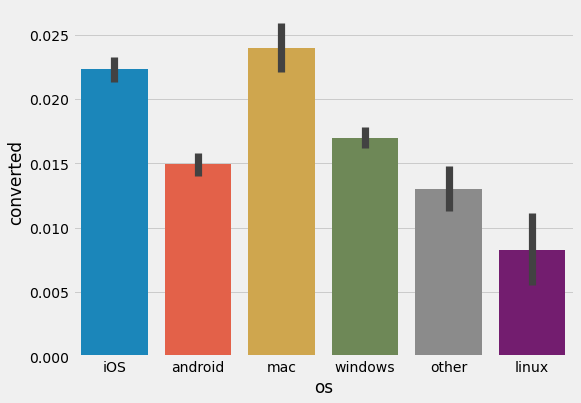

In [103]:
plt.figure(figsize=(7, 6))
sns.barplot(y='source', x='converted', data=df_joined,
            orient='h')
plt.show()

plt.figure(figsize=(8, 6))
sns.barplot(x='os', y='converted', data=df_joined)
plt.show()

可以看到，图示关键变量与模型判断结果吻合。另外，我们之前实际上已经对 [`device` 与转化率的关系⇱](#device) 进行考量过了，这里不再赘述。

### <a name="5.2"></a> 5.2 指标体系搭建

[回到目录](#toc)

在本节中，我们小试牛刀，尝试搭建一个指标体系，来跟踪关键变量，监控公司营收水平，下面以 `city` 为例。

**`city`:**

我们看到决策树 nodes 里还出现了几个城市，接着我们对 `city` 因素进行分析，生成数据透视表如下：

In [104]:
table_city = pd.pivot_table(df_joined.reset_index(),
                            values='user_id',
                            index=['city', 'price'],
                            columns='converted',
                            aggfunc='count',
                            fill_value=0)

table_city['Total'] = table_city.sum(axis=1)
table_city['Conversion Rate'] = table_city.iloc[:, 1] / table_city.Total
table_city

converted          0  1  Total  Conversion Rate
city      price                                
Abilene   39     274  7    281         0.024911
          59     149  1    150         0.006667
Akron     39     218  6    224         0.026786
          59     134  1    135         0.007407
Alameda   39     103  2    105         0.019048
...              ... ..    ...              ...
Yuba City 59       4  0      4         0.000000
Yucaipa   39     128  2    130         0.015385
          59      43  1     44         0.022727
Yuma      39     136  1    137         0.007299
          59      75  2     77         0.025974

[1830 rows x 4 columns]

让我们定义一个**新的指标**：
- **“实验效果”**，即平均营收 [(ARPU)](https://en.wikipedia.org/wiki/Average_revenue_per_user) 实验组相比对照组提升百分点。

还是以 `city` 维度为例进行搭建，拆解为三个层面，逐次递进，直捣黄龙，接近商业的本质。— A Top-Down Approach
  1. 用户数最多的城市 Top-10。
    - **有多大的蛋糕？**
    - 代表着我们的市场容量。
    - 按总数计算。
    - 如 `(149+1) + (274+7)`（以上表 `Abilene`为例，下同）
  2. 转化数最高的城市 Top-10。
    - **我们能分多少？**
    - 代表着我们的营收水平。
    - 按价格权重相加。
    - 如 `59*1 + 39*7`
  3. 实验效果最好城市 Top-10。
    - **怎么分更多？**
    - 代表着我们的增长潜力。
    - 按转化率权重相减。
    - 如 `59*1/(149+1) - 39*7/(274+7)`
    
有没有发现一种数学上的协调美呢？

- Use pandas [`Index.get_level_values()`](https://pandas.pydata.org/docs/reference/api/pandas.Index.get_level_values.html) method and set `level` parameter to get an individual level of values from a MultiIndex.

In [105]:
table_metric = table_city.copy()

table_metric['Revenue'] = table_metric.index.get_level_values(1) * \
                       table_metric.iloc[:, 1]
table_metric['ARPU'] = table_metric.index.get_level_values(1) * \
                                   table_metric['Conversion Rate']
table_metric

converted          0  1  Total  Conversion Rate  Revenue      ARPU
city      price                                                   
Abilene   39     274  7    281         0.024911      273  0.971530
          59     149  1    150         0.006667       59  0.393333
Akron     39     218  6    224         0.026786      234  1.044643
          59     134  1    135         0.007407       59  0.437037
Alameda   39     103  2    105         0.019048       78  0.742857
...              ... ..    ...              ...      ...       ...
Yuba City 59       4  0      4         0.000000        0  0.000000
Yucaipa   39     128  2    130         0.015385       78  0.600000
          59      43  1     44         0.022727       59  1.340909
Yuma      39     136  1    137         0.007299       39  0.284672
          59      75  2     77         0.025974      118  1.532468

[1830 rows x 6 columns]

- Futhermore, use pandas [`shift()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.shift.html) subtract from the "ARPU" of control group every city to calculate our experiment grow rate.

In [106]:
# Note cities may have Not been assigned to the Test
df_grow = (table_metric['ARPU'] - table_metric['ARPU'].shift(1))\
    .to_frame().query('price==59')\
    .reset_index(level=1, drop=True).rename(columns={'ARPU': 'Test Grow'})
df_grow

,Test Grow
city,
Abilene,-0.578197
Akron,-0.607606
Alameda,-0.742857
Albany,-0.203178
Alexandria,0.054762
...,...
Yorba Linda,0.000000
Youngstown,-0.037141
Yuba City,0.000000


913，少了几个城市，属于没有出现在实验组的。

让我们生成最终形态：

In [107]:
df_metric = table_metric[['Total', 'Revenue']].groupby(level=0).sum()

# we choose left join since right table has NaN
df_metric = df_metric.join(df_grow)
df_metric

,Total,Revenue,Test Grow
city,,,
Abilene,431,332,-0.578197
Akron,359,293,-0.607606
Alameda,175,78,-0.742857
Albany,545,254,-0.203178
Albuquerque,3,0,NaN
...,...,...,...
Yorba Linda,77,0,0.000000
Youngstown,186,176,-0.037141
Yuba City,25,0,0.000000


开始绘图吧：

1. 哪里蛋糕多？

<AxesSubplot:ylabel='city'>

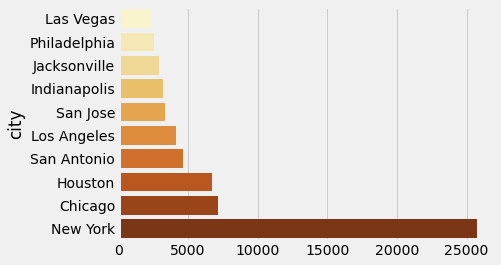

In [108]:
plot_total = df_metric['Total'].sort_values().tail(10)
sns.barplot(plot_total.values, plot_total.index, 
            palette="YlOrBr", orient='h')

用户主要集中在大城市，纽约 `New York` 独一档，公司就 Base 在这里。


2. 哪里分得多？

<AxesSubplot:ylabel='city'>

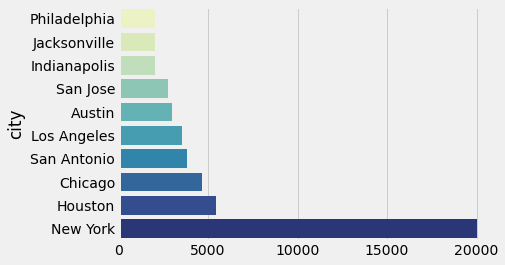

In [109]:
plot_revenue = df_metric['Revenue'].sort_values().tail(10)
sns.barplot(plot_revenue.values, plot_revenue.index,
            palette="YlGnBu", orient='h')

还是前几个，这也是一种双向选择，买方和卖方都向大城市靠拢。


3. 哪里分更多？

<AxesSubplot:ylabel='city'>

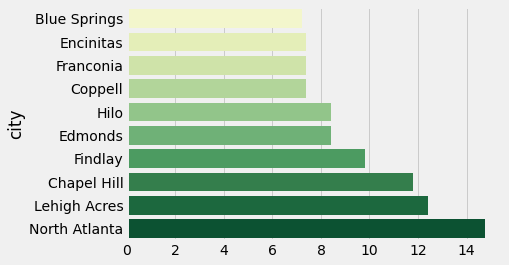

In [110]:
# Remember to drop the NaN
plot_grow = df_metric['Test Grow'].dropna().sort_values().tail(10)
sns.barplot(plot_grow.values, plot_grow.index,
            palette="YlGn", orient='h')

绿油油代表着市场的生命力。前三个城市都超过了十个百分点，而第四个 `Findlay` 之前就出现在 [决策树节点⇱](#tree-nodes) 上，因此我们还可以重点挖掘这几个城市市场的潜力，毕竟即使提高价格了，用户也不不敏感，说明需求比较刚性。

**热力图：**

让我们把目光放到更多的城市，绘制全美城市热力图，下面以 `ARPU` 为例：

In [111]:
df_city = df_user_cleaned[['city', 'lat', 'long']]\
.drop_duplicates(subset=['city'])
df_city

,city,lat,long
0,Peabody,42.53,-70.97
1,Reno,39.54,-119.82
2,Rialto,34.11,-117.39
3,Carson City,39.15,-119.74
4,Chicago,41.84,-87.68
...,...,...,...
105254,Albuquerque,35.12,-106.62
111968,Petaluma,38.24,-122.63
208922,East Lake,27.98,-82.38
260934,Ocala,29.19,-82.13


准备要连接的城市坐标表。

计算 ARPU：总营收 / 总用户数。

In [112]:
df_map = df_metric.join(df_city.set_index('city'))
df_map['ARPU'] = df_map['Revenue'] / df_map['Total']

df_map = df_map.sort_values(by='ARPU', ascending=False)
df_map

,Total,Revenue,Test Grow,lat,long,ARPU
city,,,,,,
North Atlanta,5,59,14.750000,33.86,-84.33,11.800000
Findlay,9,59,9.833333,41.04,-83.64,6.555556
Catonsville,26,156,-9.750000,39.26,-76.74,6.000000
Saint Charles,7,39,-7.800000,38.79,-90.52,5.571429
Lehigh Acres,46,236,12.421053,26.60,-81.63,5.130435
...,...,...,...,...,...,...
Minnetonka,31,0,0.000000,44.93,-93.46,0.000000
Margate,9,0,NaN,26.25,-80.21,0.000000
Laredo,23,0,0.000000,27.53,-99.49,0.000000


导出我们的画布：

<AxesSubplot:>

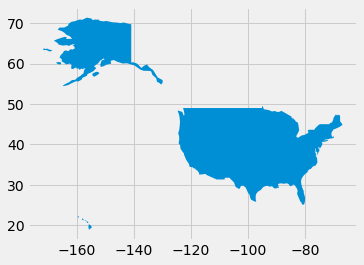

In [113]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
USA = world[world.iso_a3 == 'USA']
USA.plot()

开始绘图：

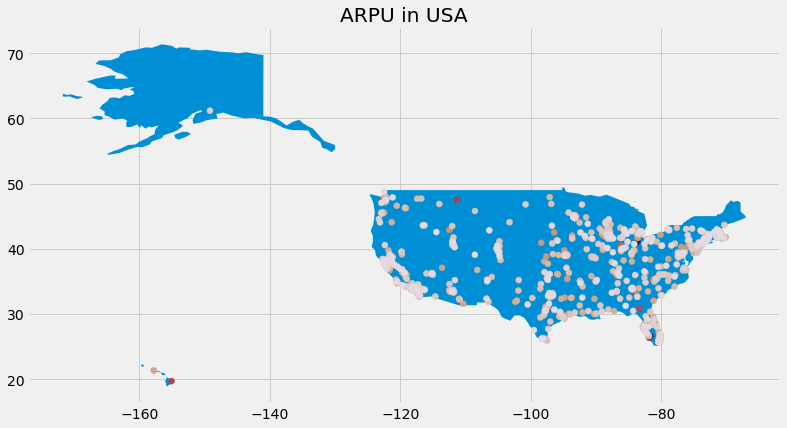

In [114]:
gdf = gpd.GeoDataFrame(
    df_map, geometry=gpd.points_from_xy(df_map.long, df_map.lat))

variable = 'ARPU'             # for whatever column we want to visualize
# vmin, vmax = gdf[variable].min(), gdf[variable].max() # with the range

figsize = (12, 9)
# fontdict = {'fontsize': 25, 'fontweight': 3}
cmap = 'twilight_r'

fig, ax = plt.subplots(1, figsize=figsize)

ax.set_title('{} in USA'.format(variable)) #, fontdict=fontdict)

USA.plot(ax=ax)
gdf.plot(ax=ax, column=variable, cmap=cmap)

# ax.set_ylabel('Latitude')
# ax.set_xlabel('Longitude')
# ax.axis('off')
plt.show()

可以看到有几个零散的城市表现突出。星星之火，可以燎原。Let's Make America Red!

### <a name="5.3"></a> 5.3 行动方案

[回到目录](#toc)

分析了那么多，是时候拿出行动方案了。— Actionable Insights

这部分可以结合之前的一系列检验实验来讲。

- 通过**地理位置**分析，用户主要集中在大城市，如东西海岸或芝加哥这样的中心城市。因此，我们可以向下面的城市渗透，比如 ARPU、营收增长前十的。
- 通过**时间序列**分析，我们找到了周期规律，临近周末是用户活跃的高峰期，可以通过策划周末活动来进行促活，提高用户转化率。
- 在**使用设备**和**操作系统**分析中，
  - 我们发现 `web` 端用户比 `mobile` 端用户的价格敏感度要更高，因此不要对这类用户使用激进的调价方案，可以采取阶梯定价（价格歧视）。
  - 苹果阵营的用户比其他生态（`windows`、`android`）的更有价值，对价格敏感度较小，我们可以重点培养这类用户的产品忠实度。
  - `linux` 用户在实验组中出现异常，我们需要调查其原因，及时解决 bug。在对照组中转化率也是最低的，后续应该提高产品在该操作系统的使用体验。
- 在**营销渠道**方面，`friend_referral` 是最有效的，加强产品口碑、给予推介人代金券、让推荐双方互发优惠券等措施都可以让我们的产品传播更广。

总的来说，就是**扬长避短**。哪些因素促进我们的营收，那么继续扩大优势；哪些因素对我们不利，就应该及时解决，是继续投入还是选择放弃，值不值得，做出抉择，避免沉没成本。

## <a name="6"></a> 6. 结语

[回到目录](#toc)

**关于实验：**

前面我们做了很多**定量分析**工作，运用了大量的统计学知识，辅以常用的经济学原理。如果要给整个项目下个**定性结论**的话，我会说：
  - **价格策略是成功的，实验设计是失败的。**

如果要我针对实验设计不足给出**建议**的话：
  - 承认有 bugs 或 bias，和负责随机化算法的数据工程团队协商，找出哪里错了，修正之后再运行实验。一般这种 bug 不会只出现在一个地方，我们要找到它们的根源，避免后续带来的风险，及时挽回损失。
  - 如果真的找不到可疑的地方，只是这些 variables 本身的问题，那我们可以适当调整它们在对照组和实验组的比例权重，使得与总体分布保持一致，再重新运行实验。

**关于项目：**

这个项目或者说是报告的工作量超出了我原本的估计，几千行的代码模块输出，让我对 **pandas** 有了更扎实的理解、更纯熟的手感。同时，随着篇幅的不断增加，掌握知识的圆圈也在扩大，往外接触的空白也越多，我愈发觉得自己的无知，对很多东西的理解还不透彻，时而顿悟，时而迷茫。通过这个项目，我又一次感受到了 Python 及其开源社区的强大，原来只要你敢想，就能实现（Where there’s a will there’s a way），很多工具都可以用 Python 来代替，不仅让我喊出 —— Python, All in One!

**Special Thanks to:**

- pandas docs: <https://pandas.pydata.org/docs/> — the only real Handbook
- Stack Overflow: <https://stackoverflow.com/> — the community you can always trust
- Jupyter: <https://jupyter.org/> — the place where I wrote
- GitHub: <https://github.com/> — all credits to the open source contributors

## <a name="7"></a> 7. 参考资料

[回到目录](#toc)

- <https://uniqiao.com/pandas>
- <https://pandas.pydata.org/pandas-docs/dev/getting_started/intro_tutorials/09_timeseries.html>
- <https://monstott.github.io/visualizing_set_diagrams_with_python>
- <https://stackoverflow.com/questions/35692781/python-plotting-percentage-in-seaborn-bar-plot>
- <https://towardsdatascience.com/styling-pandas-plots-and-charts-9b4721e9e597>
- <https://towardsdatascience.com/chi-square-test-with-python-d8ba98117626>
- <https://stats.stackexchange.com/questions/110718/chi-squared-test-with-scipy-whats-the-difference-between-chi2-contingency-and>
- <https://docs.python.org/3/howto/sorting.html>
- <https://blog.statsig.com/calculating-sample-sizes-for-a-b-tests-7854d56c2646>
- <https://geopandas.org/en/stable/gallery/create_geopandas_from_pandas.html>
- <https://matplotlib.org/stable/tutorials/colors/colormaps.html>